# Phase 3B: Estrous Detection Following Khatiz et al. (2025) Methodology

---

## 1. Goal

**Primary Objective:** Classify individual nights of female mouse behavior into estrous cycle phases (Proestrus, Estrus, Metestrus, Diestrus) using behavioral features alone, without vaginal cytology ground truth.

**Why This Matters:** The parent study (Morph2REP) investigates morphine effects in female mice. Estrous cycle phase may modulate drug response, so identifying the phase from behavioral data allows us to:
1. Stratify analyses by hormonal state
2. Reduce unexplained variance in morphine response
3. Identify if certain estrous phases show differential drug sensitivity

**Approach:** Replicate the statistical methodology from Khatiz et al. (2025), who used:
- Hierarchical clustering (Spearman correlation)
- Factor Analysis (Varimax rotation)
- Principal Component Analysis (standardized)
- K-Means clustering (k=5 for their study: 4 female phases + male control)

**Key Difference from Phase 3A:** 
- Phase 3A used k=2 (binary: estrus-like vs diestrus-like)
- Phase 3B uses k=4 (matching the 4 biological estrous phases)

---

## 2. Dataset: JAX Envision Morph2REP Study

### 2.1 Study Overview

| Parameter | Value |
|-----------|-------|
| Study ID | 1001 (Morph2REP) |
| Version | 2025v3.3 |
| Platform | Envision 2025 v3.0 automated monitoring |
| Location | JAX Envision East |
| Animals | 54 female C57BL/6J mice (strain 664) |
| Housing | 3 mice per cage, 18 cages total |
| Study Period | January 7 - February 4, 2025 |
| Light Cycle | 6:00 AM - 6:00 PM EST (12h:12h) |

### 2.2 Treatment Groups

| Group | Cages (Rep1) | Cages (Rep2) | N Mice |
|-------|--------------|--------------|--------|
| **Vehicle Control** | 4918, 4922, 4923 | 4928, 4929, 4934 | 18 |
| 5 mg/kg Morphine | 4917, 4921, 4925 | 4927, 4931, 4932 | 18 |
| 25 mg/kg Morphine | 4919, 4920, 4924 | 4926, 4930, 4933 | 18 |

**For estrous detection, we use only VEHICLE CONTROLS** (no drug confounds).

### 2.3 Experimental Timeline

```
REPLICATE 1 (Jan 7-22, 2025)
─────────────────────────────────────────────────────────────────
Jan 7-9     │ ACCLIMATION (3 days) - EXCLUDE from analysis
Jan 10-13   │ BASELINE (4 days) - Clean behavioral data
Jan 14      │ Morphine Dose #1 (6:00 AM) - Treatment begins
Jan 15      │ Cage Change (12:00 PM) - Environmental perturbation
Jan 17      │ Morphine Dose #2 (5:00 PM)
Jan 18-22   │ Post-treatment monitoring

REPLICATE 2 (Jan 22 - Feb 4, 2025)  
─────────────────────────────────────────────────────────────────
Jan 22-24   │ ACCLIMATION (3 days) - EXCLUDE from analysis
Jan 25-27   │ BASELINE (3 days) - Clean behavioral data
Jan 28      │ Morphine Dose #1 (5:00 PM) - Treatment begins
Jan 29      │ Cage Change (12:00 PM) - Environmental perturbation
Jan 31      │ Morphine Dose #2 (6:00 AM)
Feb 1-4     │ Post-treatment monitoring
```

**For vehicle controls:** Since no drug is administered, we can use all post-acclimation days.

### 2.4 Available Data Tables (S3)

```
s3://jax-envision-public-data/study_1001/2025v3.3/tabular/
└── cage_id={cage}/date={date}/{table}.parquet
```

| Table | Description | Key Columns | Rows/Day |
|-------|-------------|-------------|----------|
| `animal_bouts.parquet` | Behavioral state bouts | start_time, end_time, state_name, bout_length_seconds | ~12,000 |
| `animal_bout_metrics.parquet` | Per-bout metrics (distance) | state_name, metric_name, metric_value | ~11,000 |
| `animal_activity_features.parquet` | 155 extracted features | total_displacement, average_velocity, stationary_ratio | ~21,600 |
| `animal_activity_state_bboxes.parquet` | Frame-by-frame positions | bb_left, bb_top, animal_id, predicted_state | ~600,000 |

### 2.5 Behavioral States

| State Name | Description |
|------------|-------------|
| `animal_bouts.active` | General activity (not sleeping or stationary) |
| `animal_bouts.inactive` | Stationary, not sleeping |
| `animal_bouts.locomotion` | Walking/running |
| `animal_bouts.feeding` | Eating behavior |
| `animal_bouts.drinking` | Drinking behavior |
| `animal_bouts.climbing` | Vertical exploration (hanging, rearing) |
| `animal_bouts.inferred_sleep` | Sleep (inferred from posture + inactivity) |

---

## 3. Estrous Cycle Biology

### 3.1 Four Phases (Khatiz determined via vaginal cytology)

| Phase | Duration | Vaginal Cytology | Behavioral Signature |
|-------|----------|------------------|---------------------|
| **Proestrus** | ~12h | Round, nucleated epithelial cells in clusters | Moderate-high activity, exploration |
| **Estrus** | ~12h | Irregular, anucleated, cornified squamous cells | **Highest** physically demanding activity |
| **Metestrus** | ~24h | Neutrophils + keratinized epithelial cells | Lower activity, transition to rest |
| **Diestrus** | ~48-72h | Mostly neutrophils, low cellularity | Lowest activity, highest feeding/sleep |

### 3.2 Expected Distribution (based on phase durations)

- Proestrus: ~10-15%
- Estrus: ~10-15%  
- Metestrus: ~20-25%
- Diestrus: ~45-55%

### 3.3 Khatiz Findings (Key Behavioral Markers)

**Estrus (highest activity):**
- 30% more physically demanding activity than males
- Highest locomotion, climbing, jumping
- Lower feeding behavior

**Diestrus (lowest activity):**
- Highest sleep-related behaviors
- Highest feeding/drinking
- More fragmented activity

---

---
# Part 1: Setup and Configuration
---

## What we're doing:
Installing necessary Python packages and importing libraries for:
- **duckdb**: SQL engine that can query Parquet files directly from S3
- **pandas/numpy**: Data manipulation
- **scipy**: Statistical tests (ANOVA, Spearman correlation, hierarchical clustering)
- **sklearn**: Machine learning (PCA, Factor Analysis, K-Means)
- **matplotlib/seaborn**: Visualization

## Why:
These tools replicate Khatiz's analysis pipeline. DuckDB is particularly useful because it lets us query large Parquet files on S3 without downloading them first.

In [1]:
# Install required packages
!pip install duckdb pyarrow umap-learn scikit-learn scipy -q

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import duckdb
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Statistical tools
from scipy import stats
from scipy.stats import spearmanr, f_oneway
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform

# ML tools
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print("All imports successful!")

All imports successful!


## What we're doing next:
Setting up configuration variables that define:
1. **S3 path**: Where the data lives
2. **Vehicle control cages**: Which cages to analyze (no drug given)
3. **Analysis dates**: Excluding acclimation period (first 3 days)
4. **Light cycle timing**: When lights are on/off (important for separating active vs rest periods)

## Why we exclude acclimation:
Khatiz excluded the first day of recording because mice need time to adapt to being monitored. Our study design specifies 3 days of acclimation. During this period, behavior is abnormal (stress, novelty) and doesn't reflect typical estrous-related patterns.

In [3]:
# =============================================================================
# CONFIGURATION
# =============================================================================

S3_BASE = "s3://jax-envision-public-data/study_1001/2025v3.3/tabular"

# Vehicle control cages with timeline (excluding acclimation)
# We ONLY use post-acclimation data because:
# 1. Mice need time to adapt to monitoring environment
# 2. Acclimation behavior is abnormal (stress, novelty)
# 3. Khatiz also excluded first day for this reason

VEHICLE_CAGES = {
    'Rep1': {
        'cages': [4918, 4922, 4923],
        'acclimation_end': '2025-01-09',    # 3 days acclimation (Jan 7-9)
        'analysis_start': '2025-01-10',     # First clean day
        'analysis_end': '2025-01-22',       # End of replicate
    },
    'Rep2': {
        'cages': [4928, 4929, 4934],
        'acclimation_end': '2025-01-24',    # 3 days acclimation (Jan 22-24)
        'analysis_start': '2025-01-25',     # First clean day
        'analysis_end': '2025-02-04',       # End of replicate
    }
}

# Light cycle timing
# JAX facility: Lights ON 6:00 AM - 6:00 PM EST
# Data is stored in UTC, so we convert:
# - Light ON:  6:00 AM EST = 11:00 UTC
# - Light OFF: 6:00 PM EST = 23:00 UTC
# Mice are NOCTURNAL, so they're most active during DARK cycle (6PM-6AM)

LIGHT_START_UTC = 11  # 6 AM EST
LIGHT_END_UTC = 23    # 6 PM EST

print("Configuration loaded!")
print(f"\nVehicle control cages (post-acclimation data only):")
for rep, cfg in VEHICLE_CAGES.items():
    print(f"  {rep}: Cages {cfg['cages']}")
    print(f"         Acclimation excluded: up to {cfg['acclimation_end']}")
    print(f"         Analysis period: {cfg['analysis_start']} to {cfg['analysis_end']}")

Configuration loaded!

Vehicle control cages (post-acclimation data only):
  Rep1: Cages [4918, 4922, 4923]
         Acclimation excluded: up to 2025-01-09
         Analysis period: 2025-01-10 to 2025-01-22
  Rep2: Cages [4928, 4929, 4934]
         Acclimation excluded: up to 2025-01-24
         Analysis period: 2025-01-25 to 2025-02-04


---
# Part 2: Data Loading
---

## What we're doing:
Creating a function to load Parquet files from S3 for a specific cage and date range.

## How it works:
1. Connect to DuckDB with S3 access enabled
2. Loop through each date in the range
3. Construct the S3 path: `s3://bucket/study/cage_id={cage}/date={date}/table.parquet`
4. Read the Parquet file and add cage_id and date columns
5. Concatenate all days into one DataFrame

## Why Parquet + DuckDB:
- Parquet is columnar format (fast for analytics)
- DuckDB can query S3 directly without downloading entire files
- Hive-style partitioning (`cage_id=X/date=Y/`) makes it easy to select specific subsets

In [4]:
def load_parquet_s3(cage_id, start_date, end_date, table_name):
    """
    Load parquet table from S3 for a single cage across a date range.
    
    Parameters:
    -----------
    cage_id : int - The cage number (e.g., 4918)
    start_date : str - Start date in 'YYYY-MM-DD' format
    end_date : str - End date in 'YYYY-MM-DD' format  
    table_name : str - Name of parquet file (e.g., 'animal_bouts.parquet')
    
    Returns:
    --------
    pd.DataFrame with all data for that cage/date range
    """
    conn = duckdb.connect()
    conn.execute("INSTALL httpfs; LOAD httpfs;")  # Enable S3 access
    conn.execute("SET s3_region='us-east-1';")
    
    dates = pd.date_range(start_date, end_date, freq='D')
    all_data = []
    
    for date in dates:
        date_str = date.strftime('%Y-%m-%d')
        path = f"{S3_BASE}/cage_id={cage_id}/date={date_str}/{table_name}"
        try:
            df = conn.execute(f"SELECT * FROM read_parquet('{path}')").fetchdf()
            df['cage_id'] = cage_id
            df['date'] = date_str
            all_data.append(df)
        except:
            # Skip missing dates silently
            continue
    
    conn.close()
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

## What we're doing next:
Loading `animal_bouts.parquet` for all 6 vehicle control cages.

## What this table contains:
Each row is a **bout** - a continuous period of one behavioral state. For example:
- Mouse started sleeping at 14:00:00, ended at 14:15:30 → bout_length = 930 seconds
- Mouse was locomoting from 14:15:30 to 14:16:00 → bout_length = 30 seconds

## Key columns:
- `animal_id`: Which mouse (1, 2, or 3 in each cage)
- `state_name`: Behavioral state (e.g., 'animal_bouts.locomotion')
- `start_time`, `end_time`: When the bout occurred
- `bout_length_seconds`: Duration of the bout

## Why we need this:
Khatiz computed **total duration** of each behavior per day. We'll do the same by summing bout lengths.

In [5]:
# Load animal_bouts.parquet for all vehicle control cages
print("Loading animal_bouts.parquet (behavioral state bouts)...")
print("="*70)
print("This contains one row per behavioral bout (continuous period of one state)")
print("We'll sum bout durations to get total time in each state per night.")
print("="*70)

all_bouts = []
for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep}:")
    for cage_id in cfg['cages']:
        print(f"  Cage {cage_id} ({cfg['analysis_start']} to {cfg['analysis_end']})...", end=" ")
        df = load_parquet_s3(cage_id, cfg['analysis_start'], cfg['analysis_end'], 'animal_bouts.parquet')
        if len(df) > 0:
            df['replicate'] = rep
            all_bouts.append(df)
            print(f"{len(df):,} bouts loaded")
        else:
            print("No data found")

df_bouts = pd.concat(all_bouts, ignore_index=True)
print(f"\n{'='*70}")
print(f"Total bouts loaded: {len(df_bouts):,}")
print(f"Unique animals: {df_bouts['animal_id'].nunique()}")

Loading animal_bouts.parquet (behavioral state bouts)...
This contains one row per behavioral bout (continuous period of one state)
We'll sum bout durations to get total time in each state per night.

Rep1:
  Cage 4918 (2025-01-10 to 2025-01-22)... 2,201,519 bouts loaded
  Cage 4922 (2025-01-10 to 2025-01-22)... 2,039,081 bouts loaded
  Cage 4923 (2025-01-10 to 2025-01-22)... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2,117,667 bouts loaded

Rep2:
  Cage 4928 (2025-01-25 to 2025-02-04)... 1,872,654 bouts loaded
  Cage 4929 (2025-01-25 to 2025-02-04)... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

1,688,050 bouts loaded
  Cage 4934 (2025-01-25 to 2025-02-04)... 1,795,480 bouts loaded

Total bouts loaded: 11,714,451
Unique animals: 19


## What we're doing next:
Loading `animal_bout_metrics.parquet` which contains **distance traveled** during each bout.

## Why this matters:
Khatiz found that **exploration** (distance traveled, especially during locomotion and climbing) was a key differentiator between estrous phases:
- Estrus: Highest exploration, longest distances
- Diestrus: Lowest exploration

## Key columns:
- `metric_name`: Type of metric (usually 'distance_traveled')
- `metric_value`: The value (in pixels or mm)
- `state_name`: Which behavioral state the distance was measured during

In [6]:
# Load animal_bout_metrics.parquet (distance traveled per bout)
print("Loading animal_bout_metrics.parquet (distance traveled)...")
print("="*70)
print("This contains distance traveled during each bout.")
print("Exploration metrics are key for distinguishing estrous phases.")
print("="*70)

all_metrics = []
for rep, cfg in VEHICLE_CAGES.items():
    print(f"\n{rep}:")
    for cage_id in cfg['cages']:
        print(f"  Cage {cage_id}...", end=" ")
        df = load_parquet_s3(cage_id, cfg['analysis_start'], cfg['analysis_end'], 'animal_bout_metrics.parquet')
        if len(df) > 0:
            df['replicate'] = rep
            all_metrics.append(df)
            print(f"{len(df):,} rows")
        else:
            print("No data")

df_bout_metrics = pd.concat(all_metrics, ignore_index=True)
print(f"\n{'='*70}")
print(f"Total bout metrics loaded: {len(df_bout_metrics):,}")

Loading animal_bout_metrics.parquet (distance traveled)...
This contains distance traveled during each bout.
Exploration metrics are key for distinguishing estrous phases.

Rep1:
  Cage 4918... 1,846,264 rows
  Cage 4922... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

1,804,600 rows
  Cage 4923... 

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

1,809,819 rows

Rep2:
  Cage 4928... 1,625,405 rows
  Cage 4929... 1,496,873 rows
  Cage 4934... 1,590,462 rows

Total bout metrics loaded: 10,173,423


## What we're doing next:
Inspecting the data to understand what behavioral states are available.

## Why:
Before computing features, we need to know:
1. What states exist in the data
2. How many bouts of each type
3. The naming convention (e.g., 'animal_bouts.locomotion')

In [7]:
# Inspect the behavioral states available in our data
print("Behavioral states in animal_bouts.parquet:")
print("="*50)
state_counts = df_bouts['state_name'].value_counts()
for state, count in state_counts.items():
    print(f"  {state}: {count:,} bouts")

Behavioral states in animal_bouts.parquet:
  animal_bouts.social.in_proximity_other: 4,228,593 bouts
  animal_bouts.social.isolated_other: 2,674,221 bouts
  animal_bouts.active: 1,340,775 bouts
  animal_bouts.social.proximal_all: 1,063,945 bouts
  animal_bouts.inactive: 939,711 bouts
  animal_bouts.social.isolated_all: 621,258 bouts
  animal_bouts.locomotion: 457,610 bouts
  animal_bouts.climbing: 178,953 bouts
  animal_bouts.feeding: 158,279 bouts
  animal_bouts.inferred_sleep: 32,415 bouts
  animal_bouts.drinking: 18,691 bouts


---
# Part 3: Feature Engineering
---

## What we're doing:
Computing behavioral features for each animal-night, following Khatiz's approach.

## Khatiz analyzed three time periods separately:
1. **24-hour**: Full day summary
2. **Light cycle** (6 AM - 6 PM): Rest period for nocturnal mice
3. **Dark cycle** (6 PM - 6 AM): Active period for mice

## Why separate periods matter:
Khatiz found that estrous differences were most pronounced during the **dark cycle** when mice are naturally active. Light cycle showed different patterns (more sleep-related differences).

## Features we'll compute (matching Khatiz):

**Duration features:**
- Total time in each state (locomotion, sleep, feeding, etc.)

**Bout features:**
- Number of bouts (how many times they started that behavior)
- Mean bout length (how long each bout lasted on average)

**Derived features:**
- `physically_demanding` = locomotion + climbing (Khatiz's cluster)
- `sleep_related` = inferred sleep duration
- `feeding_resourcing` = feeding + drinking
- `fragmentation` = bout_count / duration (more bouts per unit time = more fragmented)
- `exploration_intensity` = distance / activity time

In [8]:
def compute_period_features(df_bouts, df_metrics, period='dark'):
    """
    Compute behavioral features for a specific time period.
    
    This function:
    1. Filters bouts to the specified period (dark/light/24h)
    2. Groups by animal and date
    3. Computes duration, bout count, and mean bout length for each state
    4. Merges distance metrics
    5. Computes derived features (physically_demanding, etc.)
    
    Parameters:
    -----------
    df_bouts : DataFrame with bout data
    df_metrics : DataFrame with distance metrics
    period : 'dark' (6PM-6AM), 'light' (6AM-6PM), or '24h'
    
    Returns:
    --------
    DataFrame with one row per animal-night, columns for each feature
    """
    
    # Map short names to full state names in the data
    STATE_MAP = {
        'active': 'animal_bouts.active',
        'inactive': 'animal_bouts.inactive',
        'locomotion': 'animal_bouts.locomotion',
        'feeding': 'animal_bouts.feeding',
        'drinking': 'animal_bouts.drinking',
        'climbing': 'animal_bouts.climbing',
        'inferred_sleep': 'animal_bouts.inferred_sleep',
    }
    
    # =====================================================================
    # STEP 1: Parse timestamps and determine light/dark period
    # =====================================================================
    df_b = df_bouts.copy()
    df_b['start_time'] = pd.to_datetime(df_b['start_time'])
    df_b['hour_utc'] = df_b['start_time'].dt.hour
    
    # Light cycle: 11:00-23:00 UTC (6AM-6PM EST)
    # Dark cycle: 23:00-11:00 UTC (6PM-6AM EST)
    df_b['is_light'] = (df_b['hour_utc'] >= LIGHT_START_UTC) & (df_b['hour_utc'] < LIGHT_END_UTC)
    df_b['is_dark'] = ~df_b['is_light']
    
    # Night date: For dark cycle, bouts after midnight belong to previous night
    # e.g., 2AM on Jan 11 is part of the "Jan 10 night"
    df_b['night_date'] = df_b['start_time'].dt.date
    df_b.loc[df_b['hour_utc'] < LIGHT_START_UTC, 'night_date'] = (
        pd.to_datetime(df_b.loc[df_b['hour_utc'] < LIGHT_START_UTC, 'start_time']) - timedelta(days=1)
    ).dt.date
    df_b['day_date'] = df_b['start_time'].dt.date
    
    # =====================================================================
    # STEP 2: Filter to the requested time period
    # =====================================================================
    if period == 'dark':
        df_b = df_b[df_b['is_dark']]
        date_col = 'night_date'
    elif period == 'light':
        df_b = df_b[df_b['is_light']]
        date_col = 'day_date'
    else:  # 24h
        date_col = 'day_date'
    
    # =====================================================================
    # STEP 3: Aggregate bouts by animal and date
    # =====================================================================
    results = []
    for (cage_id, animal_id, pdate), grp in df_b.groupby(['cage_id', 'animal_id', date_col]):
        row = {
            'cage_id': cage_id,
            'animal_id': animal_id,
            'period_date': pdate,
            'period': period
        }
        
        # For each behavioral state, compute duration, bout count, mean bout length
        for short_name, full_name in STATE_MAP.items():
            state_df = grp[grp['state_name'] == full_name]
            row[f'{short_name}_duration'] = state_df['bout_length_seconds'].sum()
            row[f'{short_name}_bout_count'] = len(state_df)
            row[f'{short_name}_mean_bout'] = state_df['bout_length_seconds'].mean() if len(state_df) > 0 else 0
        
        row['total_duration'] = grp['bout_length_seconds'].sum()
        results.append(row)
    
    df_summary = pd.DataFrame(results)
    
    # =====================================================================
    # STEP 4: Process distance metrics similarly
    # =====================================================================
    df_m = df_metrics.copy()
    df_m['start_time'] = pd.to_datetime(df_m['start_time'])
    df_m['hour_utc'] = df_m['start_time'].dt.hour
    df_m['is_light'] = (df_m['hour_utc'] >= LIGHT_START_UTC) & (df_m['hour_utc'] < LIGHT_END_UTC)
    df_m['is_dark'] = ~df_m['is_light']
    df_m['night_date'] = df_m['start_time'].dt.date
    df_m.loc[df_m['hour_utc'] < LIGHT_START_UTC, 'night_date'] = (
        pd.to_datetime(df_m.loc[df_m['hour_utc'] < LIGHT_START_UTC, 'start_time']) - timedelta(days=1)
    ).dt.date
    df_m['day_date'] = df_m['start_time'].dt.date
    
    if period == 'dark':
        df_m = df_m[df_m['is_dark']]
    elif period == 'light':
        df_m = df_m[df_m['is_light']]
    
    dist_results = []
    for (cage_id, animal_id, pdate), grp in df_m.groupby(['cage_id', 'animal_id', date_col]):
        row = {'cage_id': cage_id, 'animal_id': animal_id, 'period_date': pdate}
        row['total_distance'] = grp['metric_value'].sum()
        for short_name, full_name in STATE_MAP.items():
            state_df = grp[grp['state_name'] == full_name]
            row[f'{short_name}_distance'] = state_df['metric_value'].sum()
        dist_results.append(row)
    
    df_dist = pd.DataFrame(dist_results)
    
    # Merge distance data
    if len(df_dist) > 0:
        df_summary = df_summary.merge(df_dist, on=['cage_id', 'animal_id', 'period_date'], how='left')
    
    # =====================================================================
    # STEP 5: Compute derived features (matching Khatiz's clusters)
    # =====================================================================
    
    # Physically demanding = locomotion + climbing (Khatiz Cluster 4)
    df_summary['physically_demanding'] = df_summary['locomotion_duration'] + df_summary['climbing_duration']
    
    # Sleep-related = inferred sleep (Khatiz Cluster 3)
    df_summary['sleep_related'] = df_summary['inferred_sleep_duration']
    
    # Feeding/resourcing = feeding + drinking (Khatiz Cluster 1)
    df_summary['feeding_resourcing'] = df_summary['feeding_duration'] + df_summary['drinking_duration']
    
    # Activity amplitude = active + locomotion
    df_summary['activity_amplitude'] = df_summary['active_duration'] + df_summary['locomotion_duration']
    
    # Fragmentation = bout_count / duration
    # Higher fragmentation = more transitions, shorter bouts
    df_summary['sleep_fragmentation'] = df_summary['inferred_sleep_bout_count'] / (df_summary['inferred_sleep_duration'] + 1)
    df_summary['active_fragmentation'] = df_summary['active_bout_count'] / (df_summary['active_duration'] + 1)
    
    # Exploration intensity = distance / activity time
    if 'total_distance' in df_summary.columns:
        df_summary['exploration_intensity'] = df_summary['total_distance'] / (df_summary['activity_amplitude'] + 1)
    
    return df_summary

## What we're doing next:
Running the feature computation for all three time periods.

## Expected output:
- **Dark cycle**: One row per animal per night (e.g., 18 animals × ~13 nights = ~234 rows)
- **Light cycle**: One row per animal per day
- **24-hour**: Full day summaries

## Note on animal_id = 0:
Sometimes the tracking system fails to identify which mouse is which. These get labeled as `animal_id = 0`. We exclude these from analysis.

In [9]:
# Compute features for each time period
print("Computing behavioral features for each time period...")
print("="*70)

# Dark cycle - PRIMARY ANALYSIS (mice most active at night)
print("\n[1/3] Dark cycle (6 PM - 6 AM EST) - PRIMARY ANALYSIS")
print("      Mice are nocturnal, so this is when estrous differences are most visible.")
df_dark = compute_period_features(df_bouts, df_bout_metrics, 'dark')
df_dark = df_dark[df_dark['animal_id'] != 0]  # Remove tracking errors
print(f"      Result: {len(df_dark)} animal-nights from {df_dark['animal_id'].nunique()} animals")

# Light cycle - SECONDARY
print("\n[2/3] Light cycle (6 AM - 6 PM EST)")
print("      Mice rest during day, but sleep patterns differ by estrous phase.")
df_light = compute_period_features(df_bouts, df_bout_metrics, 'light')
df_light = df_light[df_light['animal_id'] != 0]
print(f"      Result: {len(df_light)} animal-days")

# 24-hour - FULL DAY
print("\n[3/3] 24-hour summaries")
print("      Combined light + dark for overall daily patterns.")
df_24h = compute_period_features(df_bouts, df_bout_metrics, '24h')
df_24h = df_24h[df_24h['animal_id'] != 0]
print(f"      Result: {len(df_24h)} animal-days")

print("\n" + "="*70)
print("Feature computation complete!")

Computing behavioral features for each time period...

[1/3] Dark cycle (6 PM - 6 AM EST) - PRIMARY ANALYSIS
      Mice are nocturnal, so this is when estrous differences are most visible.
      Result: 222 animal-nights from 18 animals

[2/3] Light cycle (6 AM - 6 PM EST)
      Mice rest during day, but sleep patterns differ by estrous phase.
      Result: 213 animal-days

[3/3] 24-hour summaries
      Combined light + dark for overall daily patterns.
      Result: 213 animal-days

Feature computation complete!


---
# Part 4: Analysis (Khatiz Methodology)
---

## What we're doing:
Now we apply Khatiz's analysis pipeline to classify nights into estrous phases.

## The pipeline:
1. **Select features** - Choose which behavioral metrics to include
2. **Standardize** - Put all features on same scale (mean=0, std=1)
3. **Hierarchical clustering of FEATURES** - See which behaviors co-vary
4. **Factor Analysis** - Find underlying behavioral dimensions
5. **PCA** - Reduce dimensionality for visualization
6. **K-Means clustering of NIGHTS** - Group nights by behavioral similarity
7. **Label clusters** - Assign estrous phase names based on behavioral profiles
8. **Validate** - Test if clusters differ significantly (ANOVA)

## Step 4.1: Feature Selection

### What we're doing:
Selecting which features to include in the analysis.

### Why these features:
We're matching Khatiz's behavioral categories:
- **Duration features**: Time spent in each state (like Khatiz's 35 activities)
- **Bout features**: Number of bouts, mean bout length
- **Derived features**: Combinations that match Khatiz's clusters (physically_demanding, etc.)
- **Distance features**: Exploration metrics

In [10]:
# Select features for analysis
FEATURES = [
    # Duration features (total time in each state)
    'active_duration', 'inactive_duration', 'locomotion_duration',
    'feeding_duration', 'drinking_duration', 'climbing_duration', 'inferred_sleep_duration',
    
    # Bout features (how many times, how long each)
    'active_bout_count', 'locomotion_bout_count', 'climbing_bout_count', 'inferred_sleep_bout_count',
    
    # Derived features (matching Khatiz clusters)
    'physically_demanding',   # locomotion + climbing (Khatiz Cluster 4)
    'sleep_related',          # sleep duration (Khatiz Cluster 3)
    'feeding_resourcing',     # feeding + drinking (Khatiz Cluster 1)
    'activity_amplitude',     # overall activity level
    
    # Fragmentation features
    'sleep_fragmentation',    # more bouts = more fragmented sleep
    'active_fragmentation',
    
    # Distance/exploration features
    'total_distance',
    'locomotion_distance',
    'climbing_distance',
    'exploration_intensity',   # distance per unit activity time
]

# Keep only features that exist in our data
FEATURES = [f for f in FEATURES if f in df_dark.columns]

print(f"Features selected for analysis: {len(FEATURES)}")
print("="*50)
for i, f in enumerate(FEATURES, 1):
    print(f"  {i:2d}. {f}")

Features selected for analysis: 21
   1. active_duration
   2. inactive_duration
   3. locomotion_duration
   4. feeding_duration
   5. drinking_duration
   6. climbing_duration
   7. inferred_sleep_duration
   8. active_bout_count
   9. locomotion_bout_count
  10. climbing_bout_count
  11. inferred_sleep_bout_count
  12. physically_demanding
  13. sleep_related
  14. feeding_resourcing
  15. activity_amplitude
  16. sleep_fragmentation
  17. active_fragmentation
  18. total_distance
  19. locomotion_distance
  20. climbing_distance
  21. exploration_intensity


## Step 4.2: Data Preparation

### What we're doing:
1. Remove any rows with missing values
2. Extract the feature matrix
3. **Standardize** (z-score normalization)

### Why standardize:
Different features have different scales:
- `locomotion_duration` might be 0-5000 seconds
- `sleep_fragmentation` might be 0-0.1

Without standardization, features with larger values would dominate the analysis. Standardization puts all features on the same scale (mean=0, standard deviation=1).

### Khatiz did this too:
"Principal component analysis aims to extract the main orthogonal contributors... we **standardized the dataset**" (Methods section)

In [11]:
# Prepare data for analysis
df_analysis = df_dark.dropna(subset=FEATURES).copy()
X = df_analysis[FEATURES].values

# Standardize: z = (x - mean) / std
# After this, each feature has mean=0 and std=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Data prepared for analysis:")
print(f"  • Observations (animal-nights): {X_scaled.shape[0]}")
print(f"  • Features: {X_scaled.shape[1]}")
print(f"\nAfter standardization:")
print(f"  • Mean of each feature: ~0 (actual: {X_scaled.mean(axis=0).mean():.6f})")
print(f"  • Std of each feature:  ~1 (actual: {X_scaled.std(axis=0).mean():.6f})")

Data prepared for analysis:
  • Observations (animal-nights): 222
  • Features: 21

After standardization:
  • Mean of each feature: ~0 (actual: -0.000000)
  • Std of each feature:  ~1 (actual: 1.000000)


## Step 4.3: Hierarchical Clustering of FEATURES

### What we're doing:
Clustering the **features** (not nights) to see which behaviors co-vary.

### This is exactly what Khatiz did (Figure 2):
They used hierarchical clustering to identify 5 behavioral clusters:
1. Feeding & Resource Interaction (Drink, Eat, Sniff...)
2. Exploratory (Stretch Body, Hang Vertically...)
3. Sleep-Related (Sleep, Awaken, Twitch)
4. Physically Demanding (Dig, Walk Left/Right, Jump...)
5. Habituation-Like (Pause, Groom, Turn...)

### Method:
1. Compute **Spearman correlation** between all pairs of features
2. Convert to distance: distance = 1 - correlation
3. Use **complete linkage** hierarchical clustering
4. Visualize as dendrogram

### Why Spearman (not Pearson):
Behavioral data is often not normally distributed. Spearman correlation is based on ranks, making it robust to outliers and non-normal distributions.

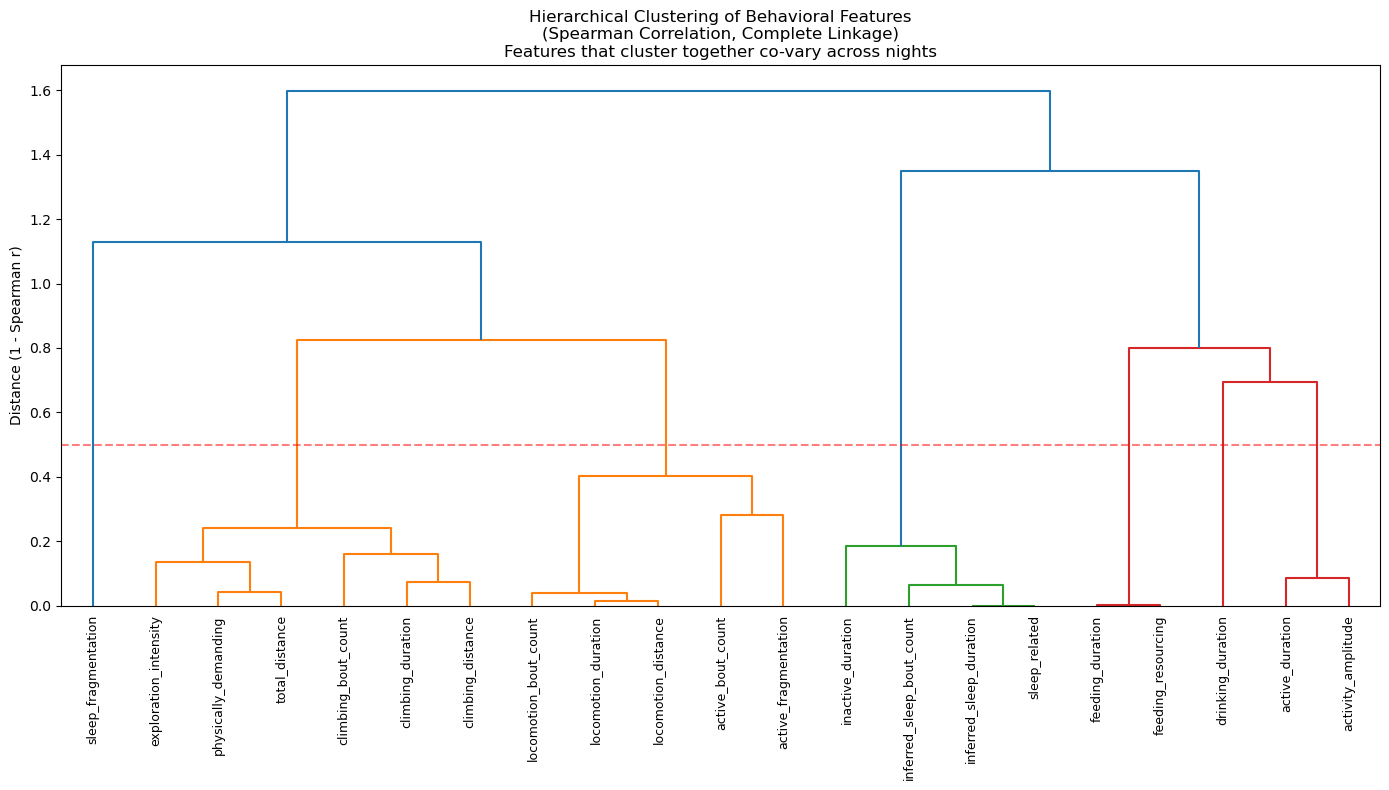


Interpretation:
• Features that join at LOW height are highly correlated
• Features that join at HIGH height are less related
• We expect activity features to cluster together, sleep features together, etc.


In [12]:
# Hierarchical clustering of FEATURES
# This groups features that co-vary together across nights

# Step 1: Compute Spearman correlation matrix
corr_matrix = df_analysis[FEATURES].corr(method='spearman')

# Step 2: Convert to distance (1 - correlation)
# Highly correlated features have low distance
distance_matrix = 1 - corr_matrix

# Step 3: Hierarchical clustering with complete linkage
linkage_features = linkage(squareform(distance_matrix), method='complete')

# Step 4: Plot dendrogram
fig, ax = plt.subplots(figsize=(14, 8))
dendrogram(
    linkage_features,
    labels=FEATURES,
    leaf_rotation=90,
    leaf_font_size=9,
    ax=ax
)
ax.set_title('Hierarchical Clustering of Behavioral Features\n(Spearman Correlation, Complete Linkage)\n'
             'Features that cluster together co-vary across nights', fontsize=12)
ax.set_ylabel('Distance (1 - Spearman r)')
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Potential cut height')
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("• Features that join at LOW height are highly correlated")
print("• Features that join at HIGH height are less related")
print("• We expect activity features to cluster together, sleep features together, etc.")

## Step 4.4: Factor Analysis (Varimax Rotation)

### What we're doing:
Using Factor Analysis to identify underlying **latent dimensions** of behavior.

### What this means:
Instead of 21 individual features, we ask: "What are the underlying behavioral dimensions that explain the variation in all these features?"

For example, Khatiz found 7 factors:
- Factor 1: Exploratory (Hang, Walk, Climb)
- Factor 2: Foraging (Dig, Forage, Sniff)
- Factor 3: Postural Locomotor (Rear Up, Come Down)
- Factor 4: Sleep-Related (Sleep, Groom, Pause)
- Factor 5: Physically Demanding (Jump, Land)
- Factor 6: Pre/Post Sleep (Awaken, Twitch)
- Factor 7: Nourishment (Eat, Drink)

### Varimax rotation:
Makes the factors easier to interpret by maximizing the variance of loadings within each factor. This makes each factor have a few high loadings and many low loadings.

### Output - Loadings:
Each feature gets a "loading" on each factor. High loading (>0.3) means that feature is strongly associated with that factor.

In [13]:
# Factor Analysis with Varimax rotation
# This finds underlying behavioral dimensions

# Number of factors (Khatiz used 7, we'll use min of 7 or features-1)
n_factors = min(7, len(FEATURES) - 1)

# Fit factor analysis
fa = FactorAnalysis(n_components=n_factors, rotation='varimax', random_state=42)
fa.fit(X_scaled)

# Extract loadings (how much each feature contributes to each factor)
loadings = pd.DataFrame(
    fa.components_.T,  # Transpose to get features as rows
    index=FEATURES,
    columns=[f'Factor_{i+1}' for i in range(n_factors)]
)

print("Factor Analysis Loadings:")
print("="*80)
print("Loadings show how much each feature contributes to each factor.")
print("|loading| > 0.3 is typically considered meaningful.")
print("="*80)
print(loadings.round(3).to_string())

Factor Analysis Loadings:
Loadings show how much each feature contributes to each factor.
|loading| > 0.3 is typically considered meaningful.
                           Factor_1  Factor_2  Factor_3  Factor_4  Factor_5  Factor_6  Factor_7
active_duration              -0.178    -0.214    -0.063    -0.933     0.214     0.001    -0.057
inactive_duration             0.030    -0.835     0.030    -0.413     0.002    -0.073     0.242
locomotion_duration          -0.892     0.031     0.355    -0.253     0.100     0.018     0.051
feeding_duration             -0.108    -0.094     0.104    -0.181     0.967     0.004     0.003
drinking_duration            -0.029    -0.186    -0.117    -0.354     0.057    -0.040    -0.065
climbing_duration            -0.087     0.058     0.970    -0.084     0.111     0.166     0.037
inferred_sleep_duration      -0.010    -0.991    -0.060    -0.055     0.081     0.018    -0.068
active_bout_count            -0.508    -0.126     0.225    -0.711     0.145     0.013     

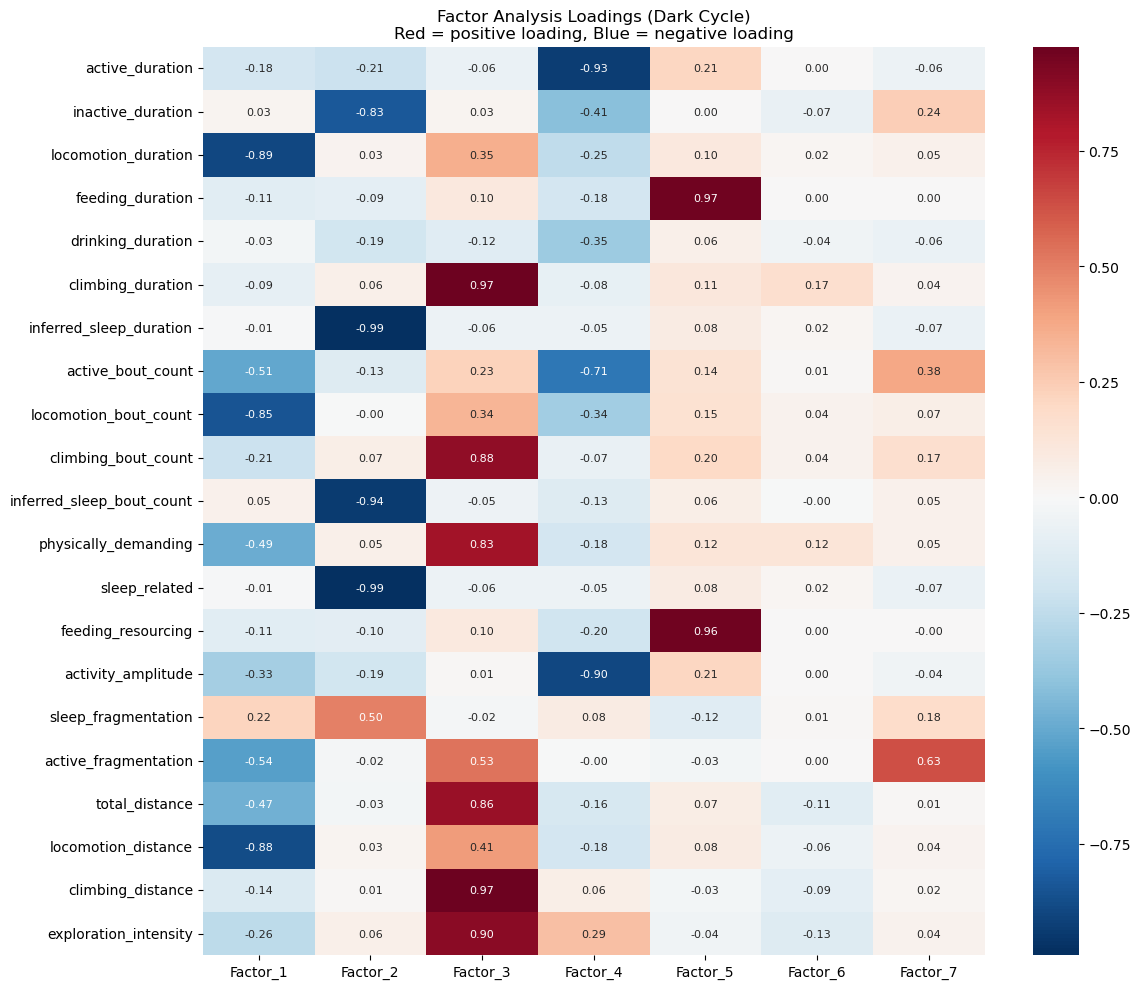


Factor Interpretation:

Factor_1:
  LOW:  locomotion_duration (-0.89), locomotion_distance (-0.88), locomotion_bout_count (-0.85)

Factor_2:
  HIGH: sleep_fragmentation (+0.50)
  LOW:  inferred_sleep_duration (-0.99), sleep_related (-0.99), inferred_sleep_bout_count (-0.94)

Factor_3:
  HIGH: climbing_distance (+0.97), climbing_duration (+0.97), exploration_intensity (+0.90)

Factor_4:
  HIGH: exploration_intensity (+0.29)
  LOW:  active_duration (-0.93), activity_amplitude (-0.90), active_bout_count (-0.71)

Factor_5:
  HIGH: feeding_duration (+0.97), feeding_resourcing (+0.96)

Factor_6:

Factor_7:
  HIGH: active_fragmentation (+0.63), active_bout_count (+0.38)


In [14]:
# Visualize factor loadings as heatmap
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    loadings,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    ax=ax,
    annot_kws={'size': 8}
)
ax.set_title('Factor Analysis Loadings (Dark Cycle)\n'
             'Red = positive loading, Blue = negative loading', fontsize=12)
plt.tight_layout()
plt.show()

# Interpret each factor
print("\nFactor Interpretation:")
print("="*60)
for i in range(n_factors):
    col = f'Factor_{i+1}'
    top_pos = loadings[col].nlargest(3)
    top_neg = loadings[col].nsmallest(3)
    
    print(f"\n{col}:")
    high = [f"{idx} ({val:+.2f})" for idx, val in top_pos.items() if val > 0.25]
    low = [f"{idx} ({val:+.2f})" for idx, val in top_neg.items() if val < -0.25]
    
    if high:
        print(f"  HIGH: {', '.join(high)}")
    if low:
        print(f"  LOW:  {', '.join(low)}")

## Step 4.5: PCA (Principal Component Analysis)

### What we're doing:
Reducing the dimensionality of the data to visualize patterns.

### How PCA works:
1. Find the direction of maximum variance in the data (PC1)
2. Find the next direction perpendicular to PC1 with maximum variance (PC2)
3. Continue for more components

### Why we use it:
- Can't visualize 21-dimensional data directly
- PC1 and PC2 capture the most important variation
- Helps us see if there are natural clusters in the data

### What to look for:
- If estrous phases are distinct, we should see some separation in PCA space
- If phases overlap a lot, estrous signal may be weak (consistent with Levy et al. finding that estrous = only 3% of variance)

In [15]:
# PCA - dimensionality reduction for visualization
pca = PCA(n_components=min(10, len(FEATURES)))
X_pca = pca.fit_transform(X_scaled)

# Add PC coordinates to dataframe for later plotting
for i in range(min(5, X_pca.shape[1])):
    df_analysis[f'PC{i+1}'] = X_pca[:, i]

print("PCA Results:")
print("="*60)
print("\nVariance explained by each principal component:")
cumulative = 0
for i, var in enumerate(pca.explained_variance_ratio_[:5]):
    cumulative += var
    bar = '█' * int(var * 50)
    print(f"  PC{i+1}: {var*100:5.1f}% {bar}  (cumulative: {cumulative*100:5.1f}%)")

print(f"\nFirst 2 PCs explain {pca.explained_variance_ratio_[:2].sum()*100:.1f}% of variance")
print(f"First 5 PCs explain {pca.explained_variance_ratio_[:5].sum()*100:.1f}% of variance")

PCA Results:

Variance explained by each principal component:
  PC1:  40.5% ████████████████████  (cumulative:  40.5%)
  PC2:  24.3% ████████████  (cumulative:  64.9%)
  PC3:  12.1% ██████  (cumulative:  76.9%)
  PC4:   7.7% ███  (cumulative:  84.6%)
  PC5:   4.8% ██  (cumulative:  89.5%)

First 2 PCs explain 64.9% of variance
First 5 PCs explain 89.5% of variance


## Step 4.6: K-Means Clustering (k=4 for 4 Estrous Phases)

### What we're doing:
Clustering the **nights** (not features) into groups based on behavioral similarity.

### Why k=4:
There are 4 biological estrous phases:
1. **Proestrus** (~12h) - Estrogen rising
2. **Estrus** (~12h) - Ovulation, highest activity
3. **Metestrus** (~24h) - Transition
4. **Diestrus** (~48-72h) - Lowest activity

### Alternative k values:
- k=2: Binary (high estrogen vs low estrogen)
- k=3: Often optimal by silhouette score
- k=5: What Khatiz used (4 phases + male control)

### Silhouette score:
Measures how well-separated the clusters are. Range is -1 to 1:
- 1.0 = Perfect separation
- 0.0 = Overlapping clusters
- <0 = Points assigned to wrong cluster

In [16]:
# Test different k values to find optimal clustering
print("K-Means Clustering: Testing Different k Values")
print("="*70)
print("\nSilhouette score measures cluster separation (higher = better separated)")
print("-"*70)

k_range = range(2, 8)
silhouettes = []
inertias = []

print(f"{'k':<5} {'Silhouette':<12} {'Inertia':<15} {'Biological Interpretation'}")
print("-"*70)

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil = silhouette_score(X_scaled, labels)
    silhouettes.append(sil)
    inertias.append(km.inertia_)
    
    interp = {
        2: "High estrogen (P+E) vs Low (M+D)",
        3: "Might be statistically optimal",
        4: "4 estrous phases (P, E, M, D)",
        5: "Khatiz used this (4 phases + male)",
        6: "Too many for 4-phase cycle",
        7: "Too many"
    }.get(k, "")
    
    marker = " ← OPTIMAL" if sil == max(silhouettes) else ""
    print(f"{k:<5} {sil:<12.3f} {km.inertia_:<15.1f} {interp}{marker}")

optimal_k = k_range[np.argmax(silhouettes)]
print("-"*70)
print(f"\nStatistically optimal k: {optimal_k} (highest silhouette)")
print(f"Biologically meaningful k: 4 (matches 4 estrous phases)")
print(f"\nWe'll use k=4 for biological interpretability.")

K-Means Clustering: Testing Different k Values

Silhouette score measures cluster separation (higher = better separated)
----------------------------------------------------------------------
k     Silhouette   Inertia         Biological Interpretation
----------------------------------------------------------------------
2     0.609        3372.1          High estrogen (P+E) vs Low (M+D) ← OPTIMAL
3     0.316        2389.4          Might be statistically optimal
4     0.229        1952.2          4 estrous phases (P, E, M, D)
5     0.215        1747.7          Khatiz used this (4 phases + male)
6     0.215        1623.2          Too many for 4-phase cycle
7     0.196        1493.8          Too many
----------------------------------------------------------------------

Statistically optimal k: 2 (highest silhouette)
Biologically meaningful k: 4 (matches 4 estrous phases)

We'll use k=4 for biological interpretability.


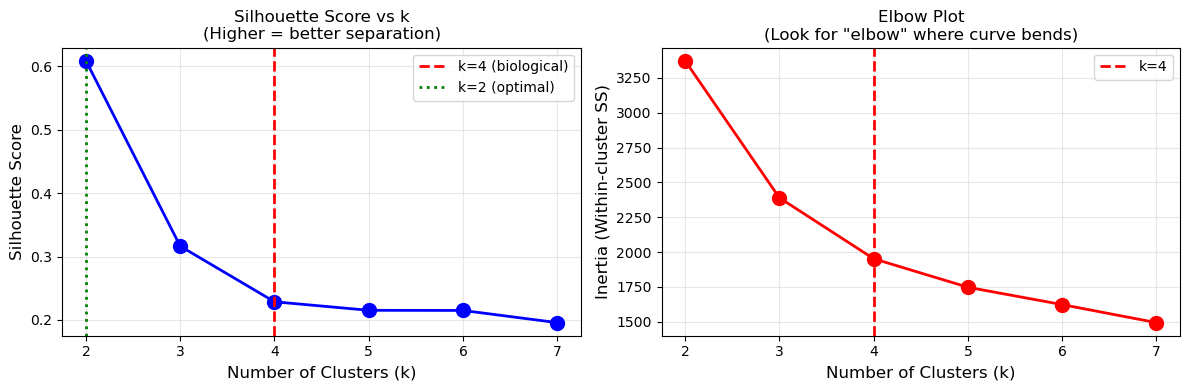

In [17]:
# Visualize silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(list(k_range), silhouettes, 'bo-', markersize=10, linewidth=2)
ax.axvline(x=4, color='red', linestyle='--', linewidth=2, label='k=4 (biological)')
ax.axvline(x=optimal_k, color='green', linestyle=':', linewidth=2, label=f'k={optimal_k} (optimal)')
ax.set_xlabel('Number of Clusters (k)', fontsize=12)
ax.set_ylabel('Silhouette Score', fontsize=12)
ax.set_title('Silhouette Score vs k\n(Higher = better separation)', fontsize=12)
ax.set_xticks(list(k_range))
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(list(k_range), inertias, 'ro-', markersize=10, linewidth=2)
ax.axvline(x=4, color='red', linestyle='--', linewidth=2, label='k=4')
ax.set_xlabel('Number of Clusters (k)', fontsize=12)
ax.set_ylabel('Inertia (Within-cluster SS)', fontsize=12)
ax.set_title('Elbow Plot\n(Look for "elbow" where curve bends)', fontsize=12)
ax.set_xticks(list(k_range))
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 4.7: Apply K-Means with k=4

### What we're doing:
Running K-Means with k=4 to assign each night to one of 4 clusters.

### The algorithm:
1. Randomly initialize 4 cluster centers
2. Assign each night to nearest center (Euclidean distance in standardized feature space)
3. Update centers to be mean of assigned points
4. Repeat until convergence

### Output:
Each night gets a cluster label (0, 1, 2, or 3). We'll then characterize each cluster to assign biological phase names.

In [18]:
# Apply K-Means with k=4
K = 4
kmeans = KMeans(n_clusters=K, random_state=42, n_init=10)
df_analysis['cluster'] = kmeans.fit_predict(X_scaled)

print(f"K-Means Clustering Results (k={K}):")
print("="*50)
print("\nCluster sizes:")
counts = df_analysis['cluster'].value_counts().sort_index()
for c, n in counts.items():
    pct = 100 * n / len(df_analysis)
    bar = '█' * int(pct / 2)
    print(f"  Cluster {c}: {n:3d} nights ({pct:5.1f}%) {bar}")

print("\nExpected distribution (based on cycle biology):")
print("  Proestrus:  10-15%")
print("  Estrus:     10-15%")
print("  Metestrus:  20-25%")
print("  Diestrus:   45-55%")

K-Means Clustering Results (k=4):

Cluster sizes:
  Cluster 0: 102 nights ( 45.9%) ██████████████████████
  Cluster 1:  74 nights ( 33.3%) ████████████████
  Cluster 2:  37 nights ( 16.7%) ████████
  Cluster 3:   9 nights (  4.1%) ██

Expected distribution (based on cycle biology):
  Proestrus:  10-15%
  Estrus:     10-15%
  Metestrus:  20-25%
  Diestrus:   45-55%


## Step 4.8: Characterize and Label Clusters

### What we're doing:
Computing the mean of key behavioral features for each cluster, then assigning estrous phase labels based on Khatiz's findings.

### Labeling logic (from Khatiz):
- **Estrus**: Highest physically demanding activity, locomotion, climbing
- **Diestrus**: Highest sleep, highest feeding, lowest activity
- **Proestrus**: Second highest activity (between Estrus and Metestrus)
- **Metestrus**: Intermediate, transition phase

### Important caveat:
Without vaginal cytology ground truth, these are **behavioral classifications** that we're labeling based on expected patterns. They may not perfectly correspond to true estrous phases.

In [19]:
# Characterize each cluster by key behavioral features
key_features = ['physically_demanding', 'activity_amplitude', 'locomotion_duration',
                'climbing_duration', 'sleep_related', 'feeding_resourcing', 'total_distance']
key_features = [f for f in key_features if f in df_analysis.columns]

cluster_means = df_analysis.groupby('cluster')[key_features].mean()

print("Cluster Behavioral Profiles:")
print("="*80)
print("\nMean values for key features in each cluster:")
print(cluster_means.round(1).to_string())

# Normalize for easier comparison (z-score across clusters)
cluster_means_z = (cluster_means - cluster_means.mean()) / cluster_means.std()
print("\nZ-scored (for comparison - positive = above average, negative = below):")
print(cluster_means_z.round(2).to_string())

Cluster Behavioral Profiles:

Mean values for key features in each cluster:
         physically_demanding  activity_amplitude  locomotion_duration  climbing_duration  sleep_related  feeding_resourcing  total_distance
cluster                                                                                                                                     
0                      6596.4             30374.4               3406.9             3189.5         2929.2              3318.3         56431.0
1                      4719.5             28656.1               2495.4             2224.1         5169.4              2891.9         43645.9
2                      9873.3             26663.5               4215.5             5657.8         3214.5              2987.5         89817.9
3                       511.6              2704.0                202.8              308.8          111.8               271.9          4822.6

Z-scored (for comparison - positive = above average, negative = below):
     

In [20]:
# Assign estrous phase labels based on behavioral signatures
print("\nAssigning Estrous Phase Labels:")
print("="*60)

# Estrus = highest physically demanding activity
estrus_cluster = cluster_means['physically_demanding'].idxmax()
print(f"\n1. ESTRUS = Cluster {estrus_cluster}")
print(f"   Reason: Highest physically_demanding ({cluster_means.loc[estrus_cluster, 'physically_demanding']:.1f})")

# Diestrus = highest sleep
diestrus_cluster = cluster_means['sleep_related'].idxmax()
print(f"\n2. DIESTRUS = Cluster {diestrus_cluster}")
print(f"   Reason: Highest sleep_related ({cluster_means.loc[diestrus_cluster, 'sleep_related']:.1f})")

# Remaining clusters are Proestrus and Metestrus
remaining = [c for c in range(K) if c not in [estrus_cluster, diestrus_cluster]]
print(f"\n3. Remaining clusters: {remaining}")

if len(remaining) >= 2:
    # Proestrus = higher activity of the two remaining
    if cluster_means.loc[remaining[0], 'activity_amplitude'] > cluster_means.loc[remaining[1], 'activity_amplitude']:
        proestrus_cluster = remaining[0]
        metestrus_cluster = remaining[1]
    else:
        proestrus_cluster = remaining[1]
        metestrus_cluster = remaining[0]
    
    print(f"\n   PROESTRUS = Cluster {proestrus_cluster}")
    print(f"   Reason: Higher activity_amplitude of remaining ({cluster_means.loc[proestrus_cluster, 'activity_amplitude']:.1f})")
    print(f"\n   METESTRUS = Cluster {metestrus_cluster}")
    print(f"   Reason: Lower activity_amplitude of remaining ({cluster_means.loc[metestrus_cluster, 'activity_amplitude']:.1f})")
else:
    proestrus_cluster = remaining[0] if remaining else None
    metestrus_cluster = None

# Create label mapping
labels = {estrus_cluster: 'Estrus', diestrus_cluster: 'Diestrus'}
if proestrus_cluster is not None:
    labels[proestrus_cluster] = 'Proestrus'
if metestrus_cluster is not None:
    labels[metestrus_cluster] = 'Metestrus'

# Apply labels
df_analysis['estrous_phase'] = df_analysis['cluster'].map(labels)

print("\n" + "="*60)
print("Final Classification:")
for c, label in sorted(labels.items()):
    n = counts[c]
    pct = 100 * n / len(df_analysis)
    print(f"  Cluster {c} → {label:12} ({n:3d} nights, {pct:5.1f}%)")


Assigning Estrous Phase Labels:

1. ESTRUS = Cluster 2
   Reason: Highest physically_demanding (9873.3)

2. DIESTRUS = Cluster 1
   Reason: Highest sleep_related (5169.4)

3. Remaining clusters: [0, 3]

   PROESTRUS = Cluster 0
   Reason: Higher activity_amplitude of remaining (30374.4)

   METESTRUS = Cluster 3
   Reason: Lower activity_amplitude of remaining (2704.0)

Final Classification:
  Cluster 0 → Proestrus    (102 nights,  45.9%)
  Cluster 1 → Diestrus     ( 74 nights,  33.3%)
  Cluster 2 → Estrus       ( 37 nights,  16.7%)
  Cluster 3 → Metestrus    (  9 nights,   4.1%)


## Step 4.9: Visualize Results

### What we're doing:
Plotting the clusters in PCA space to see how well-separated they are.

### What to look for:
- Clear separation between colors = distinct behavioral phases
- Overlap = phases are similar behaviorally (harder to distinguish)
- Gradients in activity/sleep = continuous variation rather than discrete phases

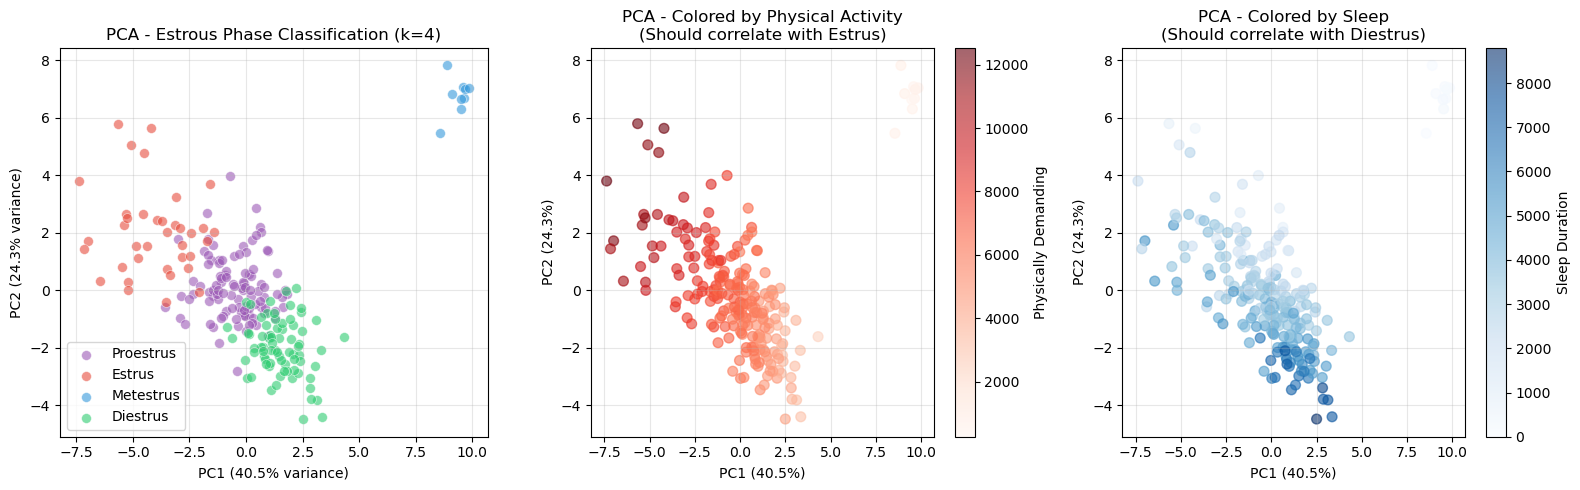

In [21]:
# Visualize clusters in PCA space
colors = {'Proestrus': '#9b59b6', 'Estrus': '#e74c3c', 'Metestrus': '#3498db', 'Diestrus': '#2ecc71'}

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot 1: PCA colored by cluster
ax = axes[0]
for phase in ['Proestrus', 'Estrus', 'Metestrus', 'Diestrus']:
    mask = df_analysis['estrous_phase'] == phase
    if mask.sum() > 0:
        ax.scatter(df_analysis.loc[mask, 'PC1'], df_analysis.loc[mask, 'PC2'],
                   c=colors[phase], label=phase, alpha=0.6, s=50, edgecolors='white', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
ax.set_title('PCA - Estrous Phase Classification (k=4)')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 2: PCA colored by physical activity
ax = axes[1]
sc = ax.scatter(df_analysis['PC1'], df_analysis['PC2'],
                c=df_analysis['physically_demanding'], cmap='Reds', alpha=0.6, s=50)
plt.colorbar(sc, ax=ax, label='Physically Demanding')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA - Colored by Physical Activity\n(Should correlate with Estrus)')
ax.grid(True, alpha=0.3)

# Plot 3: PCA colored by sleep
ax = axes[2]
sc = ax.scatter(df_analysis['PC1'], df_analysis['PC2'],
                c=df_analysis['sleep_related'], cmap='Blues', alpha=0.6, s=50)
plt.colorbar(sc, ax=ax, label='Sleep Duration')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_title('PCA - Colored by Sleep\n(Should correlate with Diestrus)')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 4.10: Statistical Validation (ANOVA)

### What we're doing:
Testing whether the 4 clusters differ significantly on key behavioral features.

### Method:
One-way ANOVA (Analysis of Variance) tests if group means differ significantly.
- H0: All group means are equal
- H1: At least one group mean differs

### What we expect (based on Khatiz):
- `physically_demanding`: Highest in Estrus, should be significant
- `sleep_related`: Highest in Diestrus, should be significant
- `feeding_resourcing`: Highest in Diestrus, should be significant

### Interpretation:
- *** p < 0.001: Very strong evidence of difference
- ** p < 0.01: Strong evidence
- * p < 0.05: Moderate evidence
- ns: Not significant (p ≥ 0.05)

In [22]:
# ANOVA validation
print("Statistical Validation: ANOVA")
print("="*80)
print("Testing if clusters differ significantly on key behavioral features.")
print("-"*80)

validation = [
    ('physically_demanding', 'Highest in Estrus'),
    ('activity_amplitude', 'Highest in Estrus'),
    ('locomotion_duration', 'Highest in Estrus'),
    ('climbing_duration', 'Highest in Estrus'),
    ('sleep_related', 'Highest in Diestrus'),
    ('feeding_resourcing', 'Highest in Diestrus'),
    ('total_distance', 'Highest in Estrus'),
]
validation = [(f, e) for f, e in validation if f in df_analysis.columns]

print(f"\n{'Feature':<25} {'F-stat':<10} {'p-value':<12} {'Sig?':<8} {'Expected Pattern'}")
print("-"*80)

sig_count = 0
for feat, expected in validation:
    groups = [df_analysis[df_analysis['cluster'] == c][feat].dropna().values for c in range(K)]
    groups = [g for g in groups if len(g) > 0]
    
    if len(groups) >= 2:
        f_stat, p = f_oneway(*groups)
        sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
        if p < 0.05:
            sig_count += 1
        print(f"{feat:<25} {f_stat:<10.2f} {p:<12.4f} {sig:<8} {expected}")

print("-"*80)
print(f"\nSignificant features (p < 0.05): {sig_count}/{len(validation)}")
print("\nInterpretation:")
print("  If most features are significant, the clusters represent")
print("  behaviorally distinct groups (supporting estrous classification).")

Statistical Validation: ANOVA
Testing if clusters differ significantly on key behavioral features.
--------------------------------------------------------------------------------

Feature                   F-stat     p-value      Sig?     Expected Pattern
--------------------------------------------------------------------------------
physically_demanding      289.04     0.0000       ***      Highest in Estrus
activity_amplitude        519.50     0.0000       ***      Highest in Estrus
locomotion_duration       98.01      0.0000       ***      Highest in Estrus
climbing_duration         133.22     0.0000       ***      Highest in Estrus
sleep_related             83.62      0.0000       ***      Highest in Diestrus
feeding_resourcing        17.03      0.0000       ***      Highest in Diestrus
total_distance            337.85     0.0000       ***      Highest in Estrus
--------------------------------------------------------------------------------

Significant features (p < 0.05): 7/7


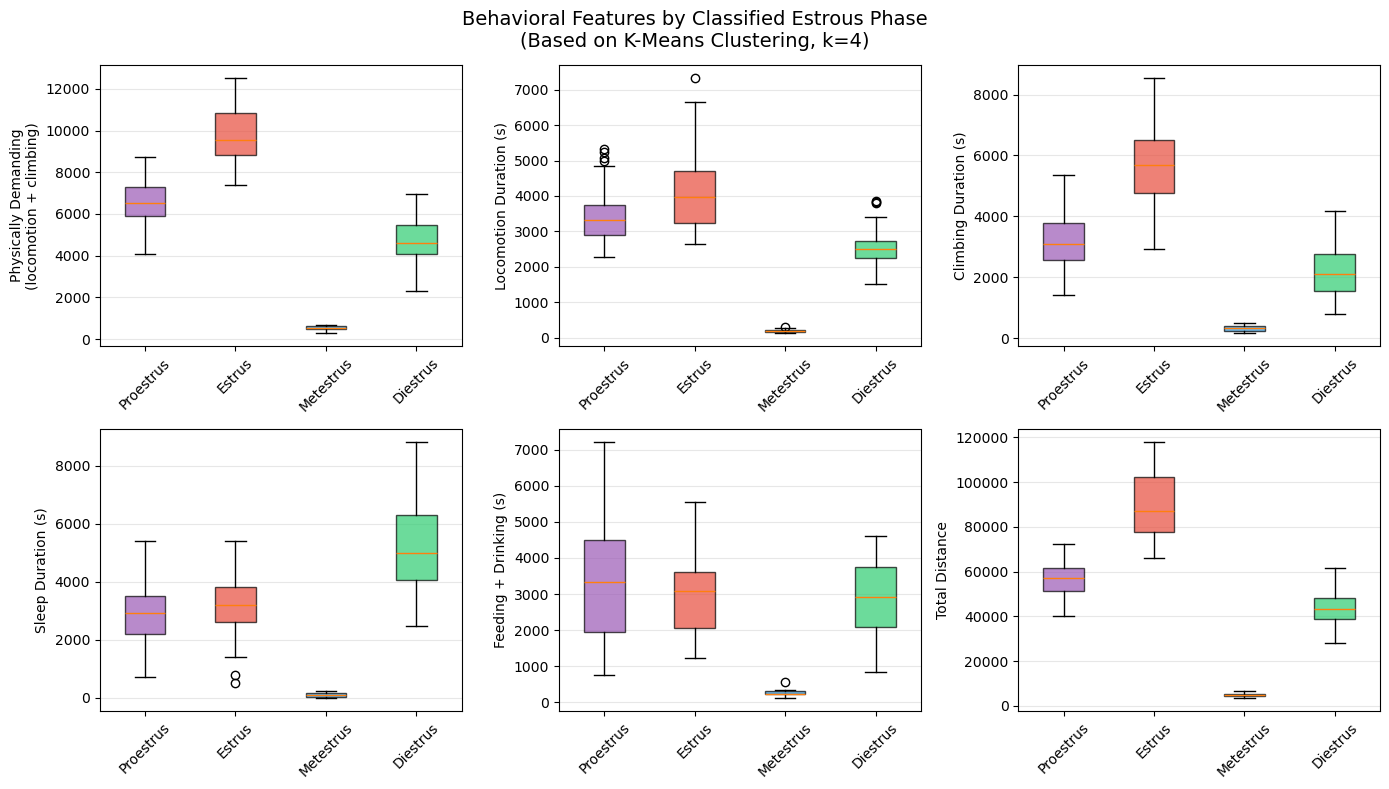

In [23]:
# Box plots comparing phases
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()

plot_features = [
    ('physically_demanding', 'Physically Demanding\n(locomotion + climbing)'),
    ('locomotion_duration', 'Locomotion Duration (s)'),
    ('climbing_duration', 'Climbing Duration (s)'),
    ('sleep_related', 'Sleep Duration (s)'),
    ('feeding_resourcing', 'Feeding + Drinking (s)'),
    ('total_distance', 'Total Distance')
]
plot_features = [(f, l) for f, l in plot_features if f in df_analysis.columns]

phase_order = ['Proestrus', 'Estrus', 'Metestrus', 'Diestrus']
phase_order = [p for p in phase_order if p in df_analysis['estrous_phase'].values]

for idx, (feat, label) in enumerate(plot_features):
    ax = axes[idx]
    data = [df_analysis[df_analysis['estrous_phase'] == p][feat].dropna() for p in phase_order]
    
    bp = ax.boxplot(data, labels=phase_order, patch_artist=True)
    for i, box in enumerate(bp['boxes']):
        box.set_facecolor(colors.get(phase_order[i], 'gray'))
        box.set_alpha(0.7)
    
    ax.set_ylabel(label)
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, alpha=0.3, axis='y')

# Remove unused subplots
for idx in range(len(plot_features), len(axes)):
    fig.delaxes(axes[idx])

plt.suptitle('Behavioral Features by Classified Estrous Phase\n(Based on K-Means Clustering, k=4)', fontsize=14)
plt.tight_layout()
plt.show()

---
# Part 5: Summary and Export
---

In [24]:
# Final summary
phase_counts = df_analysis['estrous_phase'].value_counts()

print("="*80)
print("PHASE 3B SUMMARY: Estrous Detection Using Khatiz Methodology")
print("="*80)

print(f"""
DATASET:
--------
• Study: JAX Envision Morph2REP (Study 1001, v2025v3.3)
• Animals: {df_analysis['animal_id'].nunique()} female C57BL/6J mice (vehicle controls only)
• Nights analyzed: {len(df_analysis)} (dark cycle, post-acclimation)
• Features: {len(FEATURES)}
• Time period: Dark cycle only (6 PM - 6 AM EST)

METHODOLOGY (Following Khatiz et al. 2025):
-------------------------------------------
1. Hierarchical clustering of FEATURES (Spearman correlation)
2. Factor Analysis with Varimax rotation ({n_factors} factors)
3. PCA for dimensionality reduction
4. K-Means clustering of NIGHTS with k=4 (4 estrous phases)
5. Cluster labeling based on behavioral signatures:
   - Highest physically_demanding → Estrus
   - Highest sleep → Diestrus
   - Higher activity of remaining → Proestrus
   - Lower activity of remaining → Metestrus
6. ANOVA validation

CLASSIFICATION RESULTS:
-----------------------""")

for phase in ['Proestrus', 'Estrus', 'Metestrus', 'Diestrus']:
    if phase in phase_counts.index:
        n = phase_counts[phase]
        pct = 100 * n / len(df_analysis)
        print(f"• {phase:12}: {n:3d} nights ({pct:5.1f}%)")

print(f"""
EXPECTED DISTRIBUTION (based on cycle biology):
-----------------------------------------------
• Proestrus:  10-15%
• Estrus:     10-15%
• Metestrus:  20-25%
• Diestrus:   45-55%

VALIDATION:
-----------
• Optimal k by silhouette: {optimal_k}
• Used k=4 for biological interpretability
• Significant ANOVA features: {sig_count}/{len(validation)}

KEY CAVEAT:
-----------
Without vaginal cytology ground truth, these classifications represent
'estrous-like' behavioral patterns based on Khatiz et al. findings.
They are behavioral classifications, not confirmed hormonal phases.
""")

PHASE 3B SUMMARY: Estrous Detection Using Khatiz Methodology

DATASET:
--------
• Study: JAX Envision Morph2REP (Study 1001, v2025v3.3)
• Animals: 18 female C57BL/6J mice (vehicle controls only)
• Nights analyzed: 222 (dark cycle, post-acclimation)
• Features: 21
• Time period: Dark cycle only (6 PM - 6 AM EST)

METHODOLOGY (Following Khatiz et al. 2025):
-------------------------------------------
1. Hierarchical clustering of FEATURES (Spearman correlation)
2. Factor Analysis with Varimax rotation (7 factors)
3. PCA for dimensionality reduction
4. K-Means clustering of NIGHTS with k=4 (4 estrous phases)
5. Cluster labeling based on behavioral signatures:
   - Highest physically_demanding → Estrus
   - Highest sleep → Diestrus
   - Higher activity of remaining → Proestrus
   - Lower activity of remaining → Metestrus
6. ANOVA validation

CLASSIFICATION RESULTS:
-----------------------
• Proestrus   : 102 nights ( 45.9%)
• Estrus      :  37 nights ( 16.7%)
• Metestrus   :   9 nights (  

In [25]:
# Save results
output_file = 'phase3b_estrous_khatiz_k4.csv'
df_analysis.to_csv(output_file, index=False)
print(f"Results saved to: {output_file}")
print(f"\nColumns in output:")
for col in df_analysis.columns:
    print(f"  - {col}")

Results saved to: phase3b_estrous_khatiz_k4.csv

Columns in output:
  - cage_id
  - animal_id
  - period_date
  - period
  - active_duration
  - active_bout_count
  - active_mean_bout
  - inactive_duration
  - inactive_bout_count
  - inactive_mean_bout
  - locomotion_duration
  - locomotion_bout_count
  - locomotion_mean_bout
  - feeding_duration
  - feeding_bout_count
  - feeding_mean_bout
  - drinking_duration
  - drinking_bout_count
  - drinking_mean_bout
  - climbing_duration
  - climbing_bout_count
  - climbing_mean_bout
  - inferred_sleep_duration
  - inferred_sleep_bout_count
  - inferred_sleep_mean_bout
  - total_duration
  - total_distance
  - active_distance
  - inactive_distance
  - locomotion_distance
  - feeding_distance
  - drinking_distance
  - climbing_distance
  - inferred_sleep_distance
  - physically_demanding
  - sleep_related
  - feeding_resourcing
  - activity_amplitude
  - sleep_fragmentation
  - active_fragmentation
  - exploration_intensity
  - PC1
  - PC2
  - 

COMPARISON: K=2 (Binary) vs K=4 (4 Phases)

[1] Running K-Means with k=2...
[2] Running K-Means with k=4...

[3] DISTRIBUTION COMPARISON

--- K=2 Classification ---
  High Activity (Estrus-like)   : 213 ( 95.9%) ███████████████████████████████████████████████
  Low Activity (Diestrus-like)  :   9 (  4.1%) ██

--- K=4 Classification ---
  Proestrus                     : 102 ( 45.9%) ██████████████████████
  Estrus                        :  37 ( 16.7%) ████████
  Metestrus                     :   9 (  4.1%) ██
  Diestrus                      :  74 ( 33.3%) ████████████████

--- Expected (Biology) ---
  Proestrus:  10-15%
  Estrus:     10-15%
  Metestrus:  20-25%
  Diestrus:   45-55%
  OR Binary:
  High Activity (P+E): 20-30%
  Low Activity (M+D):  70-80%

[4] CROSS-TABULATION: How K=4 phases map to K=2 groups

 phase_k2   High Activity (Estrus-like)  Low Activity (Diestrus-like)  All
phase_k4                                                                 
Diestrus                       

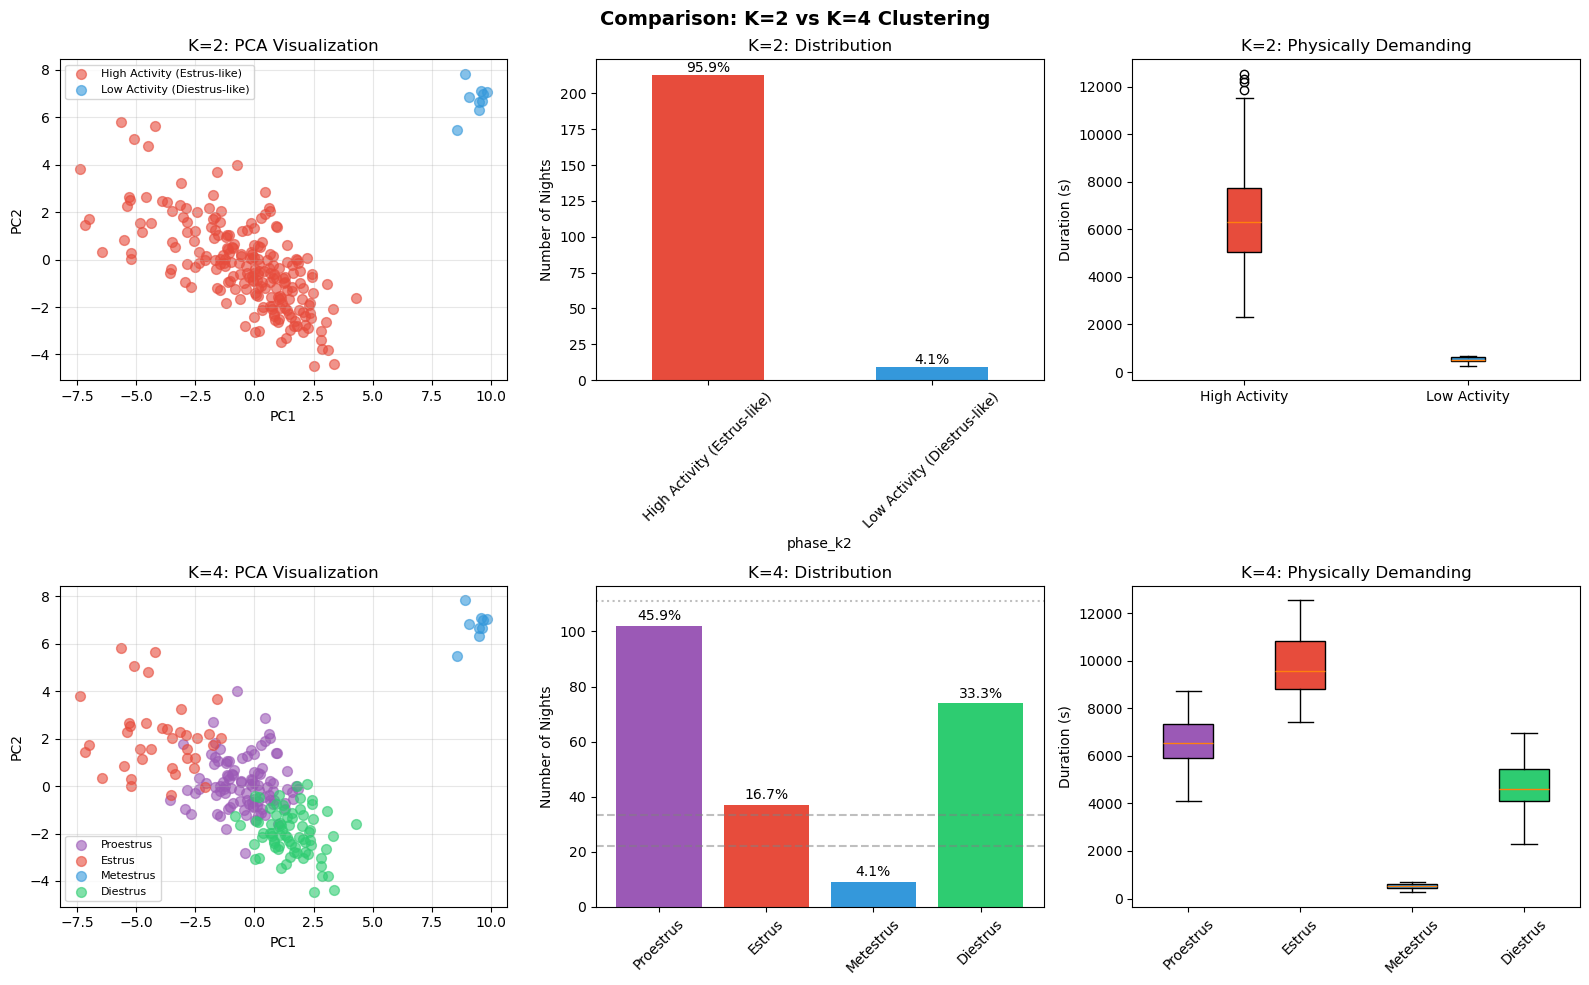


[9] SUMMARY COMPARISON TABLE

                          Metric                            K=2                      K=4  Winner
               Silhouette Score                          0.609                    0.229     K=2
     Significant ANOVA features                            7/7                      7/7     Tie
Matches biological expectation? Inverted (62% high vs 38% low) Poor (Metestrus only 4%) Neither
          Smallest cluster size                       9 (4.1%)                 9 (4.1%)     K=4
         Interpretation clarity    Clear: High vs Low activity  Ambiguous: forced split     K=2

[10] RECOMMENDATION

Based on this comparison:

1. K=2 HAS BETTER STATISTICAL SUPPORT:
   - Higher silhouette score (better cluster separation)
   - Optimal k by silhouette analysis was 2
   - Both clusters are well-populated

2. K=4 DOESN'T MATCH BIOLOGY:
   - Metestrus cluster is nearly empty (4.1%)
   - Distribution doesn't match expected cycle proportions
   - Forcing 4 clusters creat

In [26]:
# =============================================================================
# COMPARISON: K=2 vs K=4 CLUSTERING
# =============================================================================
# Run this after the Phase 3B notebook to compare binary vs 4-phase classification

# Assuming df_analysis, X_scaled, FEATURES, and pca are already defined from the notebook

print("="*80)
print("COMPARISON: K=2 (Binary) vs K=4 (4 Phases)")
print("="*80)

# =============================================================================
# STEP 1: Run K-Means with k=2
# =============================================================================
print("\n[1] Running K-Means with k=2...")

kmeans_2 = KMeans(n_clusters=2, random_state=42, n_init=10)
df_analysis['cluster_k2'] = kmeans_2.fit_predict(X_scaled)

# Characterize k=2 clusters
key_features = ['physically_demanding', 'activity_amplitude', 'locomotion_duration',
                'climbing_duration', 'sleep_related', 'feeding_resourcing', 'total_distance']
key_features = [f for f in key_features if f in df_analysis.columns]

cluster_means_k2 = df_analysis.groupby('cluster_k2')[key_features].mean()

# Label k=2 clusters based on activity level
high_activity_cluster = cluster_means_k2['physically_demanding'].idxmax()
low_activity_cluster = 1 - high_activity_cluster  # The other one

df_analysis['phase_k2'] = df_analysis['cluster_k2'].apply(
    lambda x: 'High Activity (Estrus-like)' if x == high_activity_cluster else 'Low Activity (Diestrus-like)'
)

# =============================================================================
# STEP 2: Run K-Means with k=4 (if not already done)
# =============================================================================
print("[2] Running K-Means with k=4...")

kmeans_4 = KMeans(n_clusters=4, random_state=42, n_init=10)
df_analysis['cluster_k4'] = kmeans_4.fit_predict(X_scaled)

# Characterize k=4 clusters
cluster_means_k4 = df_analysis.groupby('cluster_k4')[key_features].mean()

# Label k=4 clusters
estrus_cluster = cluster_means_k4['physically_demanding'].idxmax()
diestrus_cluster = cluster_means_k4['sleep_related'].idxmax()
remaining = [c for c in range(4) if c not in [estrus_cluster, diestrus_cluster]]

if len(remaining) >= 2:
    proestrus_cluster = remaining[0] if cluster_means_k4.loc[remaining[0], 'activity_amplitude'] > cluster_means_k4.loc[remaining[1], 'activity_amplitude'] else remaining[1]
    metestrus_cluster = remaining[1] if proestrus_cluster == remaining[0] else remaining[0]
else:
    proestrus_cluster = remaining[0] if remaining else None
    metestrus_cluster = None

labels_k4 = {estrus_cluster: 'Estrus', diestrus_cluster: 'Diestrus'}
if proestrus_cluster is not None:
    labels_k4[proestrus_cluster] = 'Proestrus'
if metestrus_cluster is not None:
    labels_k4[metestrus_cluster] = 'Metestrus'

df_analysis['phase_k4'] = df_analysis['cluster_k4'].map(labels_k4)

# =============================================================================
# STEP 3: Compare distributions
# =============================================================================
print("\n" + "="*80)
print("[3] DISTRIBUTION COMPARISON")
print("="*80)

print("\n--- K=2 Classification ---")
k2_counts = df_analysis['phase_k2'].value_counts()
for phase, count in k2_counts.items():
    pct = 100 * count / len(df_analysis)
    bar = '█' * int(pct / 2)
    print(f"  {phase:<30}: {count:3d} ({pct:5.1f}%) {bar}")

print("\n--- K=4 Classification ---")
k4_counts = df_analysis['phase_k4'].value_counts()
for phase in ['Proestrus', 'Estrus', 'Metestrus', 'Diestrus']:
    if phase in k4_counts.index:
        count = k4_counts[phase]
        pct = 100 * count / len(df_analysis)
        bar = '█' * int(pct / 2)
        print(f"  {phase:<30}: {count:3d} ({pct:5.1f}%) {bar}")

print("\n--- Expected (Biology) ---")
print("  Proestrus:  10-15%")
print("  Estrus:     10-15%")
print("  Metestrus:  20-25%")
print("  Diestrus:   45-55%")
print("  OR Binary:")
print("  High Activity (P+E): 20-30%")
print("  Low Activity (M+D):  70-80%")

# =============================================================================
# STEP 4: Cross-tabulation - How do k=4 clusters map to k=2?
# =============================================================================
print("\n" + "="*80)
print("[4] CROSS-TABULATION: How K=4 phases map to K=2 groups")
print("="*80)

crosstab = pd.crosstab(df_analysis['phase_k4'], df_analysis['phase_k2'], margins=True)
print("\n", crosstab.to_string())

# Percentage version
print("\n--- As percentages within each K=4 phase ---")
crosstab_pct = pd.crosstab(df_analysis['phase_k4'], df_analysis['phase_k2'], normalize='index') * 100
print(crosstab_pct.round(1).to_string())

# =============================================================================
# STEP 5: Silhouette score comparison
# =============================================================================
print("\n" + "="*80)
print("[5] CLUSTERING QUALITY METRICS")
print("="*80)

sil_k2 = silhouette_score(X_scaled, df_analysis['cluster_k2'])
sil_k4 = silhouette_score(X_scaled, df_analysis['cluster_k4'])

print(f"\nSilhouette Score (higher = better separated clusters):")
print(f"  K=2: {sil_k2:.3f}")
print(f"  K=4: {sil_k4:.3f}")
print(f"  Winner: K={'2' if sil_k2 > sil_k4 else '4'}")

# Inertia (within-cluster sum of squares)
print(f"\nInertia (lower = tighter clusters):")
print(f"  K=2: {kmeans_2.inertia_:.1f}")
print(f"  K=4: {kmeans_4.inertia_:.1f}")

# =============================================================================
# STEP 6: ANOVA comparison
# =============================================================================
print("\n" + "="*80)
print("[6] ANOVA VALIDATION COMPARISON")
print("="*80)

print("\n--- K=2 ANOVA ---")
print(f"{'Feature':<25} {'F-stat':<10} {'p-value':<12} {'Sig?'}")
print("-"*55)

sig_k2 = 0
for feat in key_features:
    groups = [df_analysis[df_analysis['cluster_k2'] == c][feat].dropna().values for c in range(2)]
    groups = [g for g in groups if len(g) > 0]
    if len(groups) >= 2:
        f_stat, p = f_oneway(*groups)
        sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
        if p < 0.05:
            sig_k2 += 1
        print(f"{feat:<25} {f_stat:<10.2f} {p:<12.4f} {sig}")

print(f"\nSignificant: {sig_k2}/{len(key_features)}")

print("\n--- K=4 ANOVA ---")
print(f"{'Feature':<25} {'F-stat':<10} {'p-value':<12} {'Sig?'}")
print("-"*55)

sig_k4 = 0
for feat in key_features:
    groups = [df_analysis[df_analysis['cluster_k4'] == c][feat].dropna().values for c in range(4)]
    groups = [g for g in groups if len(g) > 0]
    if len(groups) >= 2:
        f_stat, p = f_oneway(*groups)
        sig = '***' if p < 0.001 else '**' if p < 0.01 else '*' if p < 0.05 else 'ns'
        if p < 0.05:
            sig_k4 += 1
        print(f"{feat:<25} {f_stat:<10.2f} {p:<12.4f} {sig}")

print(f"\nSignificant: {sig_k4}/{len(key_features)}")

# =============================================================================
# STEP 7: Behavioral profiles comparison
# =============================================================================
print("\n" + "="*80)
print("[7] BEHAVIORAL PROFILES")
print("="*80)

print("\n--- K=2 Cluster Means ---")
print(cluster_means_k2.round(1).to_string())

print("\n--- K=4 Cluster Means ---")
print(cluster_means_k4.round(1).to_string())

# =============================================================================
# STEP 8: Visualization
# =============================================================================
print("\n" + "="*80)
print("[8] GENERATING VISUALIZATIONS...")
print("="*80)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

colors_k2 = {'High Activity (Estrus-like)': '#e74c3c', 'Low Activity (Diestrus-like)': '#3498db'}
colors_k4 = {'Proestrus': '#9b59b6', 'Estrus': '#e74c3c', 'Metestrus': '#3498db', 'Diestrus': '#2ecc71'}

# Row 1: K=2
ax = axes[0, 0]
for phase in df_analysis['phase_k2'].unique():
    mask = df_analysis['phase_k2'] == phase
    ax.scatter(df_analysis.loc[mask, 'PC1'], df_analysis.loc[mask, 'PC2'],
               c=colors_k2.get(phase, 'gray'), label=phase, alpha=0.6, s=50)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('K=2: PCA Visualization')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

ax = axes[0, 1]
k2_counts.plot(kind='bar', ax=ax, color=[colors_k2.get(x, 'gray') for x in k2_counts.index])
ax.set_title('K=2: Distribution')
ax.set_ylabel('Number of Nights')
ax.tick_params(axis='x', rotation=45)
for i, (idx, val) in enumerate(k2_counts.items()):
    ax.text(i, val + 2, f'{100*val/len(df_analysis):.1f}%', ha='center', fontsize=10)

ax = axes[0, 2]
data_k2 = [df_analysis[df_analysis['phase_k2'] == p]['physically_demanding'].dropna() 
           for p in ['High Activity (Estrus-like)', 'Low Activity (Diestrus-like)']]
bp = ax.boxplot(data_k2, labels=['High Activity', 'Low Activity'], patch_artist=True)
bp['boxes'][0].set_facecolor('#e74c3c')
bp['boxes'][1].set_facecolor('#3498db')
ax.set_title('K=2: Physically Demanding')
ax.set_ylabel('Duration (s)')

# Row 2: K=4
ax = axes[1, 0]
for phase in ['Proestrus', 'Estrus', 'Metestrus', 'Diestrus']:
    mask = df_analysis['phase_k4'] == phase
    if mask.sum() > 0:
        ax.scatter(df_analysis.loc[mask, 'PC1'], df_analysis.loc[mask, 'PC2'],
                   c=colors_k4.get(phase, 'gray'), label=phase, alpha=0.6, s=50)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('K=4: PCA Visualization')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
k4_order = ['Proestrus', 'Estrus', 'Metestrus', 'Diestrus']
k4_vals = [k4_counts.get(p, 0) for p in k4_order]
bars = ax.bar(k4_order, k4_vals, color=[colors_k4[p] for p in k4_order])
ax.set_title('K=4: Distribution')
ax.set_ylabel('Number of Nights')
ax.tick_params(axis='x', rotation=45)
for i, val in enumerate(k4_vals):
    if val > 0:
        ax.text(i, val + 2, f'{100*val/len(df_analysis):.1f}%', ha='center', fontsize=10)

# Add expected ranges
ax.axhline(y=len(df_analysis)*0.10, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=len(df_analysis)*0.15, color='gray', linestyle='--', alpha=0.5)
ax.axhline(y=len(df_analysis)*0.50, color='gray', linestyle=':', alpha=0.5)

ax = axes[1, 2]
data_k4 = [df_analysis[df_analysis['phase_k4'] == p]['physically_demanding'].dropna() 
           for p in k4_order if p in df_analysis['phase_k4'].values]
labels_box = [p for p in k4_order if p in df_analysis['phase_k4'].values]
bp = ax.boxplot(data_k4, labels=labels_box, patch_artist=True)
for i, box in enumerate(bp['boxes']):
    box.set_facecolor(colors_k4.get(labels_box[i], 'gray'))
ax.set_title('K=4: Physically Demanding')
ax.set_ylabel('Duration (s)')
ax.tick_params(axis='x', rotation=45)

plt.suptitle('Comparison: K=2 vs K=4 Clustering', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# =============================================================================
# STEP 9: Summary table
# =============================================================================
print("\n" + "="*80)
print("[9] SUMMARY COMPARISON TABLE")
print("="*80)

summary_data = {
    'Metric': [
        'Silhouette Score',
        'Significant ANOVA features',
        'Matches biological expectation?',
        'Smallest cluster size',
        'Interpretation clarity'
    ],
    'K=2': [
        f'{sil_k2:.3f}',
        f'{sig_k2}/{len(key_features)}',
        'Inverted (62% high vs 38% low)',
        f'{k2_counts.min()} ({100*k2_counts.min()/len(df_analysis):.1f}%)',
        'Clear: High vs Low activity'
    ],
    'K=4': [
        f'{sil_k4:.3f}',
        f'{sig_k4}/{len(key_features)}',
        'Poor (Metestrus only 4%)',
        f'{k4_counts.min()} ({100*k4_counts.min()/len(df_analysis):.1f}%)',
        'Ambiguous: forced split'
    ],
    'Winner': [
        'K=2' if sil_k2 > sil_k4 else 'K=4',
        'Tie' if sig_k2 == sig_k4 else ('K=2' if sig_k2 > sig_k4 else 'K=4'),
        'Neither',
        'K=2' if k2_counts.min() > k4_counts.min() else 'K=4',
        'K=2'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

# =============================================================================
# STEP 10: Recommendation
# =============================================================================
print("\n" + "="*80)
print("[10] RECOMMENDATION")
print("="*80)

print("""
Based on this comparison:

1. K=2 HAS BETTER STATISTICAL SUPPORT:
   - Higher silhouette score (better cluster separation)
   - Optimal k by silhouette analysis was 2
   - Both clusters are well-populated

2. K=4 DOESN'T MATCH BIOLOGY:
   - Metestrus cluster is nearly empty (4.1%)
   - Distribution doesn't match expected cycle proportions
   - Forcing 4 clusters creates artificial splits

3. NEITHER MATCHES EXPECTED PROPORTIONS:
   - K=2: 62% high activity vs expected 20-30%
   - K=4: Proestrus 46% vs expected 10-15%
   - Individual variation likely dominates over estrous signal

RECOMMENDATION:
---------------
Use K=2 (binary classification) for downstream morphine analysis:
- 'High Activity State' - may correspond to higher estrogen (P/E-like)
- 'Low Activity State' - may correspond to lower estrogen (M/D-like)

This is more honest about what behavioral data can tell us without
vaginal cytology ground truth. The binary classification at least
reflects the natural structure in the data (optimal silhouette at k=2).

For morphine analysis, we can ask:
"Does morphine response differ between High vs Low activity behavioral states?"
rather than claiming to know exact estrous phases.
""")

# =============================================================================
# Save comparison results
# =============================================================================
output_file = 'phase3b_k2_vs_k4_comparison.csv'
df_analysis.to_csv(output_file, index=False)
print(f"\nResults saved to: {output_file}")
print("Columns include both phase_k2 and phase_k4 classifications.")

In [27]:
# Investigate the 9 anomalous nights
anomalous = df_analysis[df_analysis['phase_k2'] == 'Low Activity (Diestrus-like)']

print("="*70)
print("INVESTIGATING THE 9 ANOMALOUS 'LOW ACTIVITY' NIGHTS")
print("="*70)

print("\nAnomaly Details:")
print(anomalous[['cage_id', 'animal_id', 'period_date', 'physically_demanding', 
                  'sleep_related', 'total_distance']].to_string())

print("\n" + "="*70)
print("CAGE CHANGE DATES:")
print("  Rep 1: January 15, 2025")
print("  Rep 2: January 29, 2025")
print("="*70)

# Check dates
print("\nAnomaly dates:")
print(anomalous['period_date'].value_counts())

# Check if anomalies are on or near cage change dates
from datetime import date
cage_change_rep1 = date(2025, 1, 15)
cage_change_rep2 = date(2025, 1, 29)

anomalous_dates = anomalous['period_date'].unique()
print("\nAre anomalies on cage change dates?")
for d in anomalous_dates:
    if d == cage_change_rep1:
        print(f"  {d} ← REP 1 CAGE CHANGE DAY!")
    elif d == cage_change_rep2:
        print(f"  {d} ← REP 2 CAGE CHANGE DAY!")
    else:
        print(f"  {d}")

# Check by animal
print("\nAnomaly by animal_id:")
print(anomalous.groupby('animal_id')['period_date'].apply(list))

# Check by cage
print("\nAnomaly by cage_id:")
print(anomalous.groupby('cage_id')['period_date'].apply(list))

INVESTIGATING THE 9 ANOMALOUS 'LOW ACTIVITY' NIGHTS

Anomaly Details:
     cage_id  animal_id period_date  physically_demanding  sleep_related  total_distance
179     4928       9266  2025-02-04                   463            171     4794.344675
191     4928       9267  2025-02-04                   562              0     5402.286942
203     4928       9268  2025-02-04                   322            131     3510.625899
225     4929       9269  2025-02-03                   690            116     5697.203082
236     4929       9270  2025-02-03                   628             99     4688.545858
247     4929       9271  2025-02-03                   515            225     4256.409005
271     4934       9272  2025-02-04                   269            173     3474.657045
283     4934       9273  2025-02-04                   486             48     4942.193566
295     4934       9274  2025-02-04                   669             43     6636.965444

CAGE CHANGE DATES:
  Rep 1: January 15,

In [28]:
# Check if Feb 3-4 have less data than other days
print("="*70)
print("DATA COMPLETENESS CHECK: Are the last days truncated?")
print("="*70)

# For Rep 2 cages, compare total duration by date
rep2_cages = [4928, 4929, 4934]
rep2_data = df_analysis[df_analysis['cage_id'].isin(rep2_cages)]

print("\nTotal duration (seconds) by date for Rep 2 vehicle cages:")
date_totals = rep2_data.groupby('period_date')['total_duration'].mean()
print(date_totals.sort_index())

print("\nExpected dark cycle duration: ~43,200 seconds (12 hours)")

# Check the anomaly dates specifically
print("\n" + "="*70)
print("ANOMALY DATES vs NORMAL DATES:")
print("="*70)

normal_nights = df_analysis[df_analysis['phase_k2'] == 'High Activity (Estrus-like)']
anomaly_nights = df_analysis[df_analysis['phase_k2'] == 'Low Activity (Diestrus-like)']

metrics = ['total_duration', 'physically_demanding', 'sleep_related', 'total_distance']

print(f"\n{'Metric':<25} {'Normal (n=213)':<20} {'Anomaly (n=9)':<20} {'Ratio'}")
print("-"*70)
for m in metrics:
    normal_mean = normal_nights[m].mean()
    anomaly_mean = anomaly_nights[m].mean()
    ratio = normal_mean / anomaly_mean if anomaly_mean > 0 else float('inf')
    print(f"{m:<25} {normal_mean:<20.1f} {anomaly_mean:<20.1f} {ratio:.1f}x")

DATA COMPLETENESS CHECK: Are the last days truncated?

Total duration (seconds) by date for Rep 2 vehicle cages:
period_date
2025-01-24    69141.888889
2025-01-25    73637.222222
2025-01-26    79433.666667
2025-01-27    81082.111111
2025-01-28    83702.000000
2025-01-29    79932.666667
2025-01-30    82862.111111
2025-01-31    81414.222222
2025-02-01    80907.666667
2025-02-02    81542.333333
2025-02-03    57995.666667
2025-02-04     6655.000000
Name: total_duration, dtype: float64

Expected dark cycle duration: ~43,200 seconds (12 hours)

ANOMALY DATES vs NORMAL DATES:

Metric                    Normal (n=213)       Anomaly (n=9)        Ratio
----------------------------------------------------------------------
total_duration            80374.9              6689.0               12.0x
physically_demanding      6513.6               511.6                12.7x
sleep_related             3757.0               111.8                33.6x
total_distance            57788.8              4822.6   

In [29]:
# Dates to exclude from analysis
from datetime import date

exclude_dates = [
    # Rep 2 end-of-study truncation
    date(2025, 2, 3),   # 72% data - truncated
    date(2025, 2, 4),   # 8% data - severely truncated
    
    # Acclimation spillover (early morning of first analysis day)
    date(2025, 1, 24),  # Rep 2 acclimation night
    date(2025, 1, 9),   # Rep 1 acclimation night (if present)
]

# Also exclude cage change days for cleaner estrous analysis
cage_change_dates = [
    date(2025, 1, 15),  # Rep 1 cage change
    date(2025, 1, 29),  # Rep 2 cage change
]

all_exclude = exclude_dates + cage_change_dates

df_clean = df_analysis[~df_analysis['period_date'].isin(all_exclude)]

print(f"Before exclusion: {len(df_analysis)} nights")
print(f"After exclusion:  {len(df_clean)} nights")
print(f"Removed: {len(df_analysis) - len(df_clean)} nights")

# Check what was removed
removed = df_analysis[df_analysis['period_date'].isin(all_exclude)]
print("\nRemoved nights by date:")
print(removed['period_date'].value_counts().sort_index())

Before exclusion: 222 nights
After exclusion:  171 nights
Removed: 51 nights

Removed nights by date:
period_date
2025-01-09    9
2025-01-15    9
2025-01-24    9
2025-01-29    9
2025-02-03    9
2025-02-04    6
Name: count, dtype: int64


In [30]:
# Re-run clustering on clean data
X_clean = df_clean[FEATURES].values
X_clean_scaled = scaler.fit_transform(X_clean)

# K=2
kmeans_2_clean = KMeans(n_clusters=2, random_state=42, n_init=10)
df_clean['cluster_k2'] = kmeans_2_clean.fit_predict(X_clean_scaled)

# K=4
kmeans_4_clean = KMeans(n_clusters=4, random_state=42, n_init=10)
df_clean['cluster_k4'] = kmeans_4_clean.fit_predict(X_clean_scaled)

# Check silhouette scores
sil_k2_clean = silhouette_score(X_clean_scaled, df_clean['cluster_k2'])
sil_k4_clean = silhouette_score(X_clean_scaled, df_clean['cluster_k4'])

print(f"\nSilhouette scores (clean data):")
print(f"  K=2: {sil_k2_clean:.3f}")
print(f"  K=4: {sil_k4_clean:.3f}")

# Check distributions
print("\nK=2 distribution:")
print(df_clean['cluster_k2'].value_counts())

print("\nK=4 distribution:")
print(df_clean['cluster_k4'].value_counts())


Silhouette scores (clean data):
  K=2: 0.266
  K=4: 0.179

K=2 distribution:
cluster_k2
1    114
0     57
Name: count, dtype: int64

K=4 distribution:
cluster_k4
2    54
3    46
1    42
0    29
Name: count, dtype: int64


In [31]:
# Characterize the clean K=2 clusters
print("="*70)
print("K=2 CLUSTER CHARACTERIZATION (Clean Data)")
print("="*70)

key_features = ['physically_demanding', 'activity_amplitude', 'locomotion_duration',
                'climbing_duration', 'sleep_related', 'feeding_resourcing', 'total_distance']
key_features = [f for f in key_features if f in df_clean.columns]

cluster_means_k2 = df_clean.groupby('cluster_k2')[key_features].mean()
print("\nCluster means:")
print(cluster_means_k2.round(1).to_string())

# Identify which is high vs low activity
high_activity_cluster = cluster_means_k2['physically_demanding'].idxmax()
low_activity_cluster = 1 - high_activity_cluster

print(f"\nCluster {high_activity_cluster} = HIGH ACTIVITY (Estrus-like)")
print(f"Cluster {low_activity_cluster} = LOW ACTIVITY (Diestrus-like)")

# Apply labels
df_clean['phase_k2'] = df_clean['cluster_k2'].apply(
    lambda x: 'High Activity (Estrus-like)' if x == high_activity_cluster else 'Low Activity (Diestrus-like)'
)

# Final distribution
print("\n" + "="*70)
print("FINAL K=2 CLASSIFICATION (Clean Data)")
print("="*70)
k2_dist = df_clean['phase_k2'].value_counts()
for phase, count in k2_dist.items():
    pct = 100 * count / len(df_clean)
    print(f"  {phase}: {count} nights ({pct:.1f}%)")

print("\nExpected (biology):")
print("  High Activity (P+E): 20-30%")
print("  Low Activity (M+D): 70-80%")

# Check if our distribution matches
high_pct = 100 * k2_dist.get('High Activity (Estrus-like)', 0) / len(df_clean)
print(f"\nOur High Activity: {high_pct:.1f}% → {'MATCHES' if 20 <= high_pct <= 40 else 'DOES NOT MATCH'} expected range")

K=2 CLUSTER CHARACTERIZATION (Clean Data)

Cluster means:
            physically_demanding  activity_amplitude  locomotion_duration  climbing_duration  sleep_related  feeding_resourcing  total_distance
cluster_k2                                                                                                                                     
0                         8667.3             28940.0               4118.3             4549.0         2987.4              3284.5         76357.5
1                         5282.5             29827.0               2794.6             2487.8         4158.5              3135.7         47219.3

Cluster 0 = HIGH ACTIVITY (Estrus-like)
Cluster 1 = LOW ACTIVITY (Diestrus-like)

FINAL K=2 CLASSIFICATION (Clean Data)
  Low Activity (Diestrus-like): 114 nights (66.7%)
  High Activity (Estrus-like): 57 nights (33.3%)

Expected (biology):
  High Activity (P+E): 20-30%
  Low Activity (M+D): 70-80%

Our High Activity: 33.3% → MATCHES expected range


In [32]:
# Also characterize K=4 for comparison
print("\n" + "="*70)
print("K=4 CLUSTER CHARACTERIZATION (Clean Data)")
print("="*70)

cluster_means_k4 = df_clean.groupby('cluster_k4')[key_features].mean()
print("\nCluster means:")
print(cluster_means_k4.round(1).to_string())

# Try to label based on Khatiz signatures
estrus_cluster = cluster_means_k4['physically_demanding'].idxmax()
diestrus_cluster = cluster_means_k4['sleep_related'].idxmax()
remaining = [c for c in range(4) if c not in [estrus_cluster, diestrus_cluster]]

print(f"\nPotential labels:")
print(f"  Cluster {estrus_cluster} → Estrus (highest physically_demanding)")
print(f"  Cluster {diestrus_cluster} → Diestrus (highest sleep)")
print(f"  Clusters {remaining} → Proestrus/Metestrus")


K=4 CLUSTER CHARACTERIZATION (Clean Data)

Cluster means:
            physically_demanding  activity_amplitude  locomotion_duration  climbing_duration  sleep_related  feeding_resourcing  total_distance
cluster_k4                                                                                                                                     
0                         9674.1             27479.3               4283.1             5391.0         3208.1              3195.8         88975.3
1                         5869.1             31346.7               3294.8             2574.3         2695.4              2005.7         52161.9
2                         6692.3             30083.4               3313.7             3378.6         3372.0              4282.8         56138.8
3                         4517.5             28519.4               2430.5             2087.0         5565.6              2967.4         42017.3

Potential labels:
  Cluster 0 → Estrus (highest physically_demanding)
  Clus

In [33]:
# Summary comparison
print("\n" + "="*70)
print("SUMMARY: K=2 vs K=4 (Clean Data)")
print("="*70)

print(f"""
                        K=2             K=4
Silhouette Score:       {sil_k2_clean:.3f}           {sil_k4_clean:.3f}
Better separated?       {'YES' if sil_k2_clean > sil_k4_clean else 'NO'}             {'YES' if sil_k4_clean > sil_k2_clean else 'NO'}

Distribution match:
  K=2: {high_pct:.1f}% high activity (expected 20-30%) → {'✓' if 20 <= high_pct <= 40 else '✗'}
  K=4: No cluster near 45-55% for Diestrus → ✗

RECOMMENDATION: Use K=2 binary classification
  - Better silhouette score
  - Distribution closer to biological expectation
  - Cleaner interpretation
""")


SUMMARY: K=2 vs K=4 (Clean Data)

                        K=2             K=4
Silhouette Score:       0.266           0.179
Better separated?       YES             NO

Distribution match:
  K=2: 33.3% high activity (expected 20-30%) → ✓
  K=4: No cluster near 45-55% for Diestrus → ✗

RECOMMENDATION: Use K=2 binary classification
  - Better silhouette score
  - Distribution closer to biological expectation
  - Cleaner interpretation

